In [1]:
import pyvista as pv
import numpy as np 
import os
import pandas as pd 
import pickle
import seaborn as sns
import scipy.stats as stats
import random as rd 
import pyvista as pv 
import matplotlib.pyplot as plt 
from scipy.spatial import distance
from nilearn.datasets import fetch_surf_fsaverage
from nilearn import surface

# Utils import
from utils.mathutils import compute_vertex_normals, build_template_adjacency_two_hemis, compute_mean_curvature, compute_curvature_differences, compute_hausdorff_metrics, compute_point_distances, compute_normal_differences
from utils.file_manip.Matlab_to_array import load_faces, load_vertices
from utils.cortical import surface_preprocess as sp
from utils.cortical import spherical_harmonics as SH
from utils.mathutils import cart_to_sph
from utils.file_manip.vtk_processing import convert_triangles_to_pyvista

In [2]:
#Folders

data_path=r"C:\Users\wbou2\Desktop\meg_to_surface_ml\src\cortical_transformation\data"
main_folder = r"C:\Users\wbou2\Desktop\meg_to_surface_ml\data\Anatomy_data_CAM_CAN"
template_projection_lh = np.load(os.path.join(data_path, "lh_sphere_projection.npz"))
template_projection_rh = np.load(os.path.join(data_path, "rh_sphere_projection.npz"))

#One subject used of examples 

sub_name="sub-CC110033"
sub_file=os.path.join(main_folder, sub_name)

In [42]:
# Load fsaverage
fsaverage7 = fetch_surf_fsaverage(mesh='fsaverage7')
surf_lh = surface.load_surf_mesh(fsaverage7['pial_left'])
surf_rh = surface.load_surf_mesh(fsaverage7['pial_right'])

# Output file 
folder_output = r"C:\Users\wbou2\Desktop\meg_to_surface_ml\data\fsaverage"
os.makedirs(folder_output, exist_ok=True)

# Left Hemi
surface_mesh_lh = (surf_lh[0], surf_lh[1])
coords_lh, tris_lh = sp.get_resampled_inner_surface(surface_mesh_lh, 'lh')
center_lh = np.mean(coords_lh, axis=0)
coords_lh = coords_lh - center_lh
output_file_lh = os.path.join(folder_output, "lh_resampled.npz")
np.savez(output_file_lh, coords=coords_lh, tris=tris_lh, center=center_lh)

# Right hemi
surface_mesh_rh = (surf_rh[0], surf_rh[1])
coords_rh, tris_rh = sp.get_resampled_inner_surface(surface_mesh_rh, 'rh')
center_rh = np.mean(coords_rh, axis=0)
coords_rh = coords_rh - center_rh
output_file_rh = os.path.join(folder_output, "rh_resampled.npz")
np.savez(output_file_rh, coords=coords_rh, tris=tris_rh, center=center_rh)


Input mesh size: 163842 vertices
Executing: python c:\users\wbou2\desktop\meg_to_surface_ml\utils\cortical\S3MAP-main\s3all.py -i C:\Users\wbou2\AppData\Local\Temp\lh.brain.vtk --save_interim_results True --device CPU
Input mesh size: 163842 vertices
Executing: python c:\users\wbou2\desktop\meg_to_surface_ml\utils\cortical\S3MAP-main\s3all.py -i C:\Users\wbou2\AppData\Local\Temp\rh.brain.vtk --save_interim_results True --device CPU


In [6]:
#Paramaters
lmax = 80
sigma=1e-7
lambda_reg=1e-7
n_subjects=len(os.listdir(main_folder))
sns.set_theme(style="whitegrid")

In [35]:
#Utils 
def register(surface, output_file):
    coords, tris = surface
    if not output_file.endswith(".npz"):
        output_file+=".npz"
    np.savez(output_file, coords=coords, tris=tris)    

In [7]:
# Load hemisphere-specific harmonics and slice according to lmax (limited to lmax<=80)
Y_lh_full = np.load(os.path.join(data_path, "Y_lh.npz"))['Y']
Y_rh_full = np.load(os.path.join(data_path, "Y_rh.npz"))['Y']

# Left hemisphere uses first part, right hemisphere uses second part
Y_lh = Y_lh_full[:, :(lmax+1)**2]
Y_rh = Y_rh_full[:, :(lmax+1)**2:]

In [9]:
# Save resampled cortical surfaces
for folder in os.listdir(main_folder):
    folder_path = os.path.join(main_folder, folder)
    if os.path.isdir(folder_path):
        print(f"Processing subject: {folder}")
        try:
            left_vertices_file = os.path.join(folder_path, "lh_vertices.mat")
            left_faces_file = os.path.join(folder_path, "lh_faces.mat")
            output_file = os.path.join(folder_path, "lh_resampled.npz")
            
            left_faces = load_faces(left_faces_file)
            left_vertices = load_vertices(left_vertices_file)
            coords, tris = sp.get_resampled_inner_surface((left_vertices, left_faces), 'lh')
            center = np.mean(coords, axis=0)
            coords = coords - center
            np.savez(output_file, coords=coords, tris=tris, center=center)
            print(f"  Left hemisphere processed successfully")

        except Exception as e:
            print(f"  Error processing left hemisphere: {str(e)}")
        
        try:
            right_vertices_file = os.path.join(folder_path, "rh_vertices.mat")
            right_faces_file = os.path.join(folder_path, "rh_faces.mat")
            output_file = os.path.join(folder_path, "rh_resampled.npz")
            
            right_faces = load_faces(right_faces_file)
            right_vertices = load_vertices(right_vertices_file)
            coords, tris = sp.get_resampled_inner_surface((right_vertices, right_faces), 'rh')
            center = np.mean(coords, axis=0)
            coords = coords - center
            np.savez(output_file, coords=coords, tris=tris, center=center)
            print(f"  Right hemisphere processed successfully")
        except Exception as e:
            print(f"  Error processing right hemisphere: {str(e)}")


Processing subject: sub-CC110033
Input mesh size: 138175 vertices


KeyboardInterrupt: 

In [46]:
fsaverage_path=r"C:\Users\wbou2\Desktop\meg_to_surface_ml\data\fsaverage"
# Load resampled data!
fsav_lh = np.load(os.path.join(fsaverage_path, "lh_resampled.npz"))
fsav_rh = np.load(os.path.join(fsaverage_path, "rh_resampled.npz"))

# Prepare resampled surfaces for coefficient computation
resampled_lh = (fsav_lh['coords'], fsav_lh['tris'])
resampled_rh = (fsav_rh['coords'], fsav_rh['tris'])

# Compute coefficients for both hemispheres
coeffs_fsav_lh = SH.compute_coefficients_SVD(Y_lh, resampled_lh, lmax, lambda_reg=lambda_reg)
coeffs_fsav_rh = SH.compute_coefficients_SVD(Y_rh, resampled_rh, lmax, lambda_reg=lambda_reg)

# Save coefficients
with open(os.path.join(fsaverage_path, "coeffs_lh.pkl"), 'wb') as f:
    pickle.dump(coeffs_fsav_lh, f)
with open(os.path.join(fsaverage_path, "coeffs_rh.pkl"), 'wb') as f:
    pickle.dump(coeffs_fsav_rh, f)

In [ ]:
# Save coefficients for each hemisphere of each subject
for folder in os.listdir(main_folder):
    folder_path = os.path.join(main_folder, folder)
    if os.path.isdir(folder_path):
        coeffs_lh_path = os.path.join(folder_path, "coeffs_lh.pkl")
        coeffs_rh_path = os.path.join(folder_path, "coeffs_rh.pkl")
        
        # Load hemisphere-specific harmonics and slice according to lmax
        Y_lh_full = np.load(os.path.join(data_path, "Y_lh.npz"))['Y']
        Y_rh_full = np.load(os.path.join(data_path, "Y_rh.npz"))['Y']
        
        # Left hemisphere uses first part, right hemisphere uses second part
        Y_lh = Y_lh_full[:, :(lmax+1)**2]
        Y_rh = Y_rh_full[:, :(lmax+1)**2:]
        
        print(f"Processing left hemi of {folder}")
        left_resampled_data = np.load(os.path.join(folder_path, "lh_resampled.npz"))
        
        # Smooth the left hemisphere surface
        left_smoothed_coords = sp.smooth_surface(left_resampled_data['coords'], 
                                           left_resampled_data['tris'],
                                           n_iterations=5, 
                                           relaxation_factor=0.5)
        
        coeffs_lh = SH.compute_coefficients_SVD(Y_lh, 
                                              (left_smoothed_coords, left_resampled_data['tris']), 
                                              lmax, 
                                              lambda_reg)
        with open(coeffs_lh_path, 'wb') as f:
            pickle.dump(coeffs_lh, f)
        
        print(f"Processing right hemi of {folder}")
        right_resampled_data = np.load(os.path.join(folder_path, "rh_resampled.npz"))
        
        # Smooth the right hemisphere surface
        right_smoothed_coords = sp.smooth_surface(right_resampled_data['coords'], 
                                            right_resampled_data['tris'],
                                            n_iterations=5, 
                                            relaxation_factor=0.5)
        
        coeffs_rh = SH.compute_coefficients_SVD(Y_rh,
                                              (right_smoothed_coords, right_resampled_data['tris']),
                                              lmax, 
                                              lambda_reg)
        with open(coeffs_rh_path, 'wb') as f:
            pickle.dump(coeffs_rh, f)

In [31]:
import os
import numpy as np
import pickle
from pathlib import Path
from tqdm import tqdm
from datetime import datetime
from utils.mathutils import (hausdorff_distance, compute_normal_differences,
                           compute_mean_curvature, build_template_adjacency_two_hemis,
                           compute_vertex_normals, compute_face_normals)
import matplotlib.pyplot as plt

# Structure de stockage pour les métriques
means_by_l = {
   'lh': {metric: [] for metric in ['hausdorff_norm', 'normal_errors', 'curvature_errors', 'high_angle_percent']},
   'rh': {metric: [] for metric in ['hausdorff_norm', 'normal_errors', 'curvature_errors', 'high_angle_percent']}
}

# Définir les valeurs de l
l_values = list(range(1, 50)) + list(range(50, lmax + 1, 2))

# Progress bar
pbar = tqdm(l_values, desc="Processing l values")

# Création vertex_to_faces une seule fois
vertex_to_faces = build_template_adjacency_two_hemis(template_tris_lh, template_tris_rh)

for l in pbar:
   current_l_metrics = {
       'lh': {metric: [] for metric in ['hausdorff_norm', 'normal_errors', 'curvature_errors', 'high_angle_percent']},
       'rh': {metric: [] for metric in ['hausdorff_norm', 'normal_errors', 'curvature_errors', 'high_angle_percent']}
   }
   
   # Truncate Y for this order
   Y_l = Y[:, :(l+1)**2]
   
   for folder in os.listdir(main_folder):
       folder_path = os.path.join(main_folder, folder)
       if not os.path.isdir(folder_path):
           continue
           
       try:
           for hemi in ['lh', 'rh']:
               # Charger les données
               with open(os.path.join(folder_path, f"coeffs_{hemi}.pkl"), 'rb') as f:
                   coeffs = pickle.load(f)
               org_coeffs = {i: coeffs['organized_coeffs'][i] for i in range(l+1)}
               resampled_data = np.load(os.path.join(folder_path, f"{hemi}_resampled.npz"))
               recon_surface = SH.generate_surface(Y_l, l, 0, org_coeffs)

               # Calcul de la taille caractéristique 
               char_size = np.max(np.ptp(resampled_data['coords'], axis=0))
               
               # Calcul des normales
               resampled_normals = compute_vertex_normals(resampled_data['coords'], 
                                                        resampled_data['tris'], 
                                                        vertex_to_faces)
               recon_normals = compute_vertex_normals(recon_surface, 
                                                    resampled_data['tris'], 
                                                    vertex_to_faces)
               
               # Calcul des courbures
               resampled_curv = compute_mean_curvature(resampled_data['coords'], 
                                                     resampled_data['tris'], 
                                                     vertex_to_faces)
               recon_curv = compute_mean_curvature(recon_surface, 
                                                 resampled_data['tris'], 
                                                 vertex_to_faces)
               
               # Calcul des métriques
               hausdorff = hausdorff_distance(resampled_data['coords'], recon_surface) 
               hausdorff_norm = hausdorff / char_size
               normal_diff = compute_normal_differences(resampled_normals, recon_normals)
               
               # Stockage des métriques
               current_l_metrics[hemi]['hausdorff_norm'].append(hausdorff_norm)
               current_l_metrics[hemi]['normal_errors'].append(normal_diff['mean_angle'])
               current_l_metrics[hemi]['high_angle_percent'].append(normal_diff['percent_large_errors'])
               current_l_metrics[hemi]['curvature_errors'].append(
                   np.mean(np.abs(resampled_curv - recon_curv))
               )
               
       except Exception as e:
           print(f"Erreur pour {folder} à l'ordre {l}: {str(e)}")
           continue
   
   # Calcul des moyennes pour cet ordre l
   for hemi in ['lh', 'rh']:
       for metric in means_by_l[hemi].keys():
           if current_l_metrics[hemi][metric]:
               means_by_l[hemi][metric].append(np.mean(current_l_metrics[hemi][metric]))
           else:
               means_by_l[hemi][metric].append(np.nan)
   
   # Sauvegarde intermédiaire tous les 10 l
   if l % 10 == 0:
       with open(f'metrics_backup_l_{l}.pkl', 'wb') as f:
           pickle.dump(means_by_l, f)

# Plot des résultats
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

metrics = ['hausdorff_norm', 'normal_errors', 'curvature_errors', 'high_angle_percent']
titles = ['Normalized Hausdorff Distance', 'Mean Normal Angle Error (degrees)', 
         'Mean Curvature Error', 'Percentage of Normal Errors > 45°']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
   for hemi in ['lh', 'rh']:
       axes[idx].plot(l_values, means_by_l[hemi][metric], 
                    label=f'{hemi.upper()}', 
                    marker='o', markersize=2)
   axes[idx].set_xlabel('l-value')
   axes[idx].set_ylabel(title)
   axes[idx].set_xscale('log')
   axes[idx].grid(True)
   axes[idx].legend()

plt.tight_layout()
plt.show()

# Sauvegarde finale
with open('final_metrics.pkl', 'wb') as f:
   pickle.dump({'metrics': means_by_l, 'l_values': l_values}, f)

ImportError: cannot import name 'compute_normal_differences' from 'utils.mathutils' (c:\users\wbou2\desktop\meg_to_surface_ml\utils\mathutils.py)

Analysis of the error across subjects (mean over subject)

In [75]:
def mean_reconstruction(l, main_folder, output_path):
    first_path = os.path.join(main_folder, os.listdir(main_folder)[0])
    tris = np.load(os.path.join(first_path, "lh_resampled.npz"))['tris']
    mean_coords_lh = np.zeros(shape=(40962, 3))
    mean_coords_rh = np.zeros(shape=(40962, 3))
    n_subjects = len([f for f in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, f))])
    
    for folder in os.listdir(main_folder):
        folder_path = os.path.join(main_folder, folder)
        if os.path.isdir(folder_path):
            Y_l = Y[:, :(l+1)**2]
            
            # Left hemisphere
            with open(os.path.join(folder_path, "coeffs_lh.pkl"), 'rb') as f:
                coeffs_lh = pickle.load(f)
            org_coeffs_lh = {i: coeffs_lh['organized_coeffs'][i] for i in range(l+1)}
            mean_coords_lh += SH.generate_surface(Y_l, l, 0, org_coeffs_lh)

            # Right hemisphere
            with open(os.path.join(folder_path, "coeffs_rh.pkl"), 'rb') as f:
                coeffs_rh = pickle.load(f)
            org_coeffs_rh = {i: coeffs_rh['organized_coeffs'][i] for i in range(l+1)}
            mean_coords_rh += SH.generate_surface(Y_l, l, 0, org_coeffs_rh)
    
    mean_coords_lh /= n_subjects
    mean_coords_rh /= n_subjects
    
    # Save results
    os.makedirs(output_path, exist_ok=True)
    np.savez(os.path.join(output_path, f'mean_brain_l{l}.npz'),
             coords_lh=mean_coords_lh,
             coords_rh=mean_coords_rh,
             tris=tris)
            

In [ ]:
def collect_error_distributions(l, main_folder, Y):
    collected_data = {
        'lh': {
            'raw_distributions': {
                'point_errors': [],    
                'distance_errors': [], 
                'angle_errors': [],    
                'area_errors': []      
            },
            'normalization_factors': []
        },
        'rh': {
            'raw_distributions': {
                'point_errors': [],
                'distance_errors': [],
                'angle_errors': [],
                'area_errors': []
            },
            'normalization_factors': []
        }
    }
    
    Y_l = Y[:, :(l+1)**2]
    
    for folder in os.listdir(main_folder):
        folder_path = os.path.join(main_folder, folder)
        if os.path.isdir(folder_path):
            # Left hemisphere
            with open(os.path.join(folder_path, "coeffs_lh.pkl"), 'rb') as f:
                coeffs_lh = pickle.load(f)
            org_coeffs_lh = {i: coeffs_lh['organized_coeffs'][i] for i in range(l+1)}
            resampled_data_lh = np.load(os.path.join(folder_path, "lh_resampled.npz"))
            recon_surface_lh = SH.generate_surface(Y_l, l, 0, org_coeffs_lh)
            
            orig_metrics_lh = compute_raw_surface_metrics(resampled_data_lh['coords'], resampled_data_lh['tris'])
            recon_metrics_lh = compute_raw_surface_metrics(recon_surface_lh, resampled_data_lh['tris'])
            comparison_lh = compare_surface_metrics(orig_metrics_lh, recon_metrics_lh)
            
            for metric in collected_data['lh']['raw_distributions'].keys():
                collected_data['lh']['raw_distributions'][metric].append(comparison_lh['raw_distributions'][metric])
            collected_data['lh']['normalization_factors'].append(comparison_lh['normalization_factors'])
            
            # Right hemisphere
            with open(os.path.join(folder_path, "coeffs_rh.pkl"), 'rb') as f:
                coeffs_rh = pickle.load(f)
            org_coeffs_rh = {i: coeffs_rh['organized_coeffs'][i] for i in range(l+1)}
            resampled_data_rh = np.load(os.path.join(folder_path, "rh_resampled.npz"))
            recon_surface_rh = SH.generate_surface(Y_l, l, 0, org_coeffs_rh)
            
            orig_metrics_rh = compute_raw_surface_metrics(resampled_data_rh['coords'], resampled_data_rh['tris'])
            recon_metrics_rh = compute_raw_surface_metrics(recon_surface_rh, resampled_data_rh['tris'])
            comparison_rh = compare_surface_metrics(orig_metrics_rh, recon_metrics_rh)
            
            for metric in collected_data['rh']['raw_distributions'].keys():
                collected_data['rh']['raw_distributions'][metric].append(comparison_rh['raw_distributions'][metric])
            collected_data['rh']['normalization_factors'].append(comparison_rh['normalization_factors'])
    
    # Save all data in a single file
    filename = f'raw_error_distributions_l{l}.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(collected_data, f)

In [ ]:
for l in orders:
    collect_error_distributions(l, main_folder, Y)

In [ ]:
def get_unique_pairs(data):
    flattened_data = []
    for v in range(data.shape[0]):
        vertex_data = data[v]
        for i in range(vertex_data.shape[0]):
            for j in range(i+1, vertex_data.shape[0]):
                flattened_data.extend([vertex_data[i], vertex_data[j]])
    return np.array(flattened_data)

def plot_error_distribution(raw_data, norm_data, z_scores, title, color, hemi):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))
    
    ax1.hist(raw_data, bins=50, color=color, alpha=0.5, label=f'{hemi.upper()}')
    ax1.set_title(f'{title} (Raw/Characteristic Size)')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    sns.kdeplot(data=norm_data, ax=ax2, color=color, alpha=0.5, fill=True, label=f'{hemi.upper()}')
    ax2.set_title(f'{title} (Normalized)')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    sns.kdeplot(data=z_scores, ax=ax3, color=color, alpha=0.5, fill=True, label=f'{hemi.upper()}')
    ax3.set_title(f'{title} (Z-scores)')
    ax3.axvline(x=2, color='red', linestyle='--', alpha=0.5)
    ax3.axvline(x=-2, color='red', linestyle='--', alpha=0.5)
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    
    plt.show()

def analyze_all_metrics(l):
    with open(f'raw_error_distributions_l{l}.pkl', 'rb') as f:
        data = pickle.load(f)
    
    for hemi in ['lh', 'rh']:
        raw_dist = data[hemi]['raw_distributions']
        norm_factors = data[hemi]['normalization_factors']
        color = '#2E86C1' if hemi=='lh' else '#E74C3C'
        
        # Point Errors
        if 'point_errors' in raw_dist:
            raw = np.array(raw_dist['point_errors'])
            raw_norm_char = np.array([raw[i] / norm_factors[i]['characteristic_size'] for i in range(len(norm_factors))])
            raw_norm_char_mean = np.mean(raw_norm_char, axis=0)
            
            norm = np.array([raw[i] / norm_factors[i]['characteristic_size'] for i in range(len(norm_factors))])
            norm_mean = np.mean(norm, axis=0)
            
            z_scores = (norm_mean - np.mean(norm_mean)) / np.std(norm_mean)
            
            plot_error_distribution(raw_norm_char_mean, norm_mean, z_scores, 
                                 f'Point Errors (l={l})', color, hemi)
        
        # Area Errors
        if 'area_errors' in raw_dist:
            raw = np.array(raw_dist['area_errors'])
            raw_norm_char = np.array([raw[i] / norm_factors[i]['total_area'] for i in range(len(norm_factors))])
            raw_norm_char_mean = np.mean(raw_norm_char, axis=0)
            
            norm = np.array([raw[i] / norm_factors[i]['total_area'] for i in range(len(norm_factors))])
            norm_mean = np.mean(norm, axis=0)
            
            z_scores = (norm_mean - np.mean(norm_mean)) / np.std(norm_mean)
            
            plot_error_distribution(raw_norm_char_mean.flatten(), norm_mean.flatten(), z_scores.flatten(), 
                                 f'Area Errors (l={l})', color, hemi)
        
        # Distance Errors
        if 'distance_errors' in raw_dist:
            raw = np.array(raw_dist['distance_errors'])
            raw_norm_char = np.array([raw[i] / norm_factors[i]['mean_geodesic'] for i in range(len(norm_factors))])
            raw_norm_char_mean = np.mean(raw_norm_char, axis=0)
            
            norm = np.array([raw[i] / norm_factors[i]['mean_geodesic'] for i in range(len(norm_factors))])
            norm_mean = np.mean(norm, axis=0)
            
            z_scores = (norm_mean - np.mean(norm_mean)) / np.std(norm_mean)
            
            flat_raw = get_unique_pairs(raw_norm_char_mean)
            flat_norm = get_unique_pairs(norm_mean)
            flat_z = get_unique_pairs(z_scores)
            
            plot_error_distribution(flat_raw, flat_norm, flat_z,
                                 f'Distance Errors (l={l})', color, hemi)
        
        # Angle Errors
        if 'angle_errors' in raw_dist:
            raw = np.array(raw_dist['angle_errors'])
            raw_norm_char = np.array([raw[i] / norm_factors[i]['pi'] for i in range(len(norm_factors))])
            raw_norm_char_mean = np.mean(raw_norm_char, axis=0)
            
            norm = np.array([raw[i] / norm_factors[i]['pi'] for i in range(len(norm_factors))])
            norm_mean = np.mean(norm, axis=0)
            
            z_scores = (norm_mean - np.mean(norm_mean)) / np.std(norm_mean)
            
            flat_raw = get_unique_pairs(raw_norm_char_mean)
            flat_norm = get_unique_pairs(norm_mean)
            flat_z = get_unique_pairs(z_scores)
            
            plot_error_distribution(flat_raw, flat_norm, flat_z,
                                 f'Angle Errors (l={l})', color, hemi)

print("Starting analysis...")
for l in orders:
    try:
        analyze_all_metrics(l)
        print(f"Completed analysis for l={l}")
    except Exception as e:
        print(f"Failed to process l={l}: {str(e)}")
print("Analysis completed")

Visualization of the errors (to see what are the outliers)

In [79]:
def visualize_outliers_metrics(l, mean_brain_path, error_data_path, threshold=2):
    mean_data = np.load(mean_brain_path)
    with open(error_data_path, 'rb') as f:
        error_data = pickle.load(f)
    
    metrics = {
        'point_errors': 'characteristic_size',
        'area_errors': 'total_area',
        'distance_errors': 'mean_geodesic',
        'angle_errors': 'pi'
    }

    plotter = pv.Plotter(shape=(4, 2))  # 4 metrics x 2 hemispheres
    
    for idx, (metric_name, norm_factor_key) in enumerate(metrics.items()):
        for j, hemi in enumerate(['lh', 'rh']):
            plotter.subplot(idx, j)
            
            coords = mean_data[f'coords_{hemi}']
            tris = mean_data['tris']
            raw = np.array(error_data[hemi]['raw_distributions'][metric_name])
            norm_factors = error_data[hemi]['normalization_factors']
            
            norm = np.array([raw[i] / norm_factors[i][norm_factor_key] for i in range(len(norm_factors))])
            norm_mean = np.mean(norm, axis=0)
            z_scores = (norm_mean - np.mean(norm_mean)) / np.std(norm_mean)
            
            mesh = pv.PolyData(coords, np.hstack([np.full((len(tris), 1), 3), tris]))
            mesh.point_data['outliers'] = (np.abs(z_scores) > threshold).astype(int)
            
            plotter.add_mesh(mesh, scalars='outliers', cmap=['gray', 'red'])
            plotter.view_xy()
            plotter.add_text(f'{metric_name} - {hemi}')
    plotter.link_views()
    plotter.show()

In [93]:
visualize_outliers_metrics(50, 'mean_brain_l50.npz', 'raw_error_distributions_l50.pkl')

Widget(value='<iframe src="http://localhost:3497/index.html?ui=P_0x1cf15105e20_13&reconnect=auto" class="pyvis…

In [ ]:
# def compare_original_surfaces(main_folder):

#     results = {'lh': [], 'rh': []}
    
#     # Initialize one distance matrix per hemisphere
#     dist_matrix_lh = np.zeros((n_subjects, n_subjects))
#     dist_matrix_rh = np.zeros((n_subjects, n_subjects))
    
#     # Lists to store all surfaces before computing distances
#     surfaces_lh = []
#     surfaces_rh = []
    
#     # Load all original surfaces from npz files
#     for folder in os.listdir(main_folder):
#         folder_path = os.path.join(main_folder, folder)
#         if os.path.isdir(folder_path):
#             # Left hemisphere: load coordinates from npz file
#             data_lh = np.load(os.path.join(folder_path, "lh_resampled.npz"))
#             coords_lh = data_lh['coords'] 
#             surfaces_lh.append(coords_lh)
            
#             # Right hemisphere: same process
#             data_rh = np.load(os.path.join(folder_path, "rh_resampled.npz"))
#             coords_rh = data_rh['coords']
#             surfaces_rh.append(coords_rh)
    
#     # Convert lists to numpy arrays for efficient computation
#     surfaces_lh = np.array(surfaces_lh)  # Shape: (n_subjects, n_vertices, 3)
#     surfaces_rh = np.array(surfaces_rh)
    
#     # Compute pairwise distances between all subjects
#     for i in range(n_subjects):
#         for j in range(i+1, n_subjects):
#             # Calculate mean Euclidean distance between corresponding vertices
#             dist_lh = np.mean(np.sqrt(np.sum((surfaces_lh[i] - surfaces_lh[j])**2, axis=1)))
#             dist_rh = np.mean(np.sqrt(np.sum((surfaces_rh[i] - surfaces_rh[j])**2, axis=1)))
            
#             dist_matrix_lh[i, j] = dist_lh
#             dist_matrix_lh[j, i] = dist_lh
#             dist_matrix_rh[i, j] = dist_rh
#             dist_matrix_rh[j, i] = dist_rh
    
#     results['lh'].append(dist_matrix_lh)
#     results['rh'].append(dist_matrix_rh)
    
#     return results

In [ ]:
# def compare_reconstructions(main_folder, SH, Y, lmax):
#     results = {'lh': [], 'rh': []}
    
#     for l in range(lmax + 1):
#         # Initialize distance matrices for each hemisphere
#         dist_matrix_lh = np.zeros((n_subjects, n_subjects))
#         dist_matrix_rh = np.zeros((n_subjects, n_subjects))
        
#         # Get all reconstructed surfaces for this order l
#         surfaces_lh = []
#         surfaces_rh = []
        
#         # First, reconstruct all surfaces
#         for folder in os.listdir(main_folder):
#             folder_path = os.path.join(main_folder, folder)
#             if os.path.isdir(folder_path):
#                 # Left hemisphere
#                 with open(os.path.join(folder_path, "coeffs_lh.pkl"), 'rb') as f:
#                     coeffs_lh = pickle.load(f)['organized_coeffs']
#                 recon_lh = SH.generate_surface(Y, l, 0, coeffs_lh)
#                 surfaces_lh.append(recon_lh)
                
#                 # Right hemisphere
#                 with open(os.path.join(folder_path, "coeffs_rh.pkl"), 'rb') as f:
#                     coeffs_rh = pickle.load(f)['organized_coeffs']
#                 recon_rh = SH.generate_surface(Y, l, 0, coeffs_rh)
#                 surfaces_rh.append(recon_rh)
        
#         # Convert to numpy arrays
#         surfaces_lh = np.array(surfaces_lh)
#         surfaces_rh = np.array(surfaces_rh)
        
#         # Calculate pairwise distances
#         for i in range(n_subjects):
#             for j in range(i+1, n_subjects):
#                 # Euclidean distance between surfaces
#                 dist_lh = np.mean(np.sqrt(np.sum((surfaces_lh[i] - surfaces_lh[j])**2, axis=1)))
#                 dist_rh = np.mean(np.sqrt(np.sum((surfaces_rh[i] - surfaces_rh[j])**2, axis=1)))
                
#                 dist_matrix_lh[i, j] = dist_lh
#                 dist_matrix_lh[j, i] = dist_lh
#                 dist_matrix_rh[i, j] = dist_rh
#                 dist_matrix_rh[j, i] = dist_rh
        
#         results['lh'].append(dist_matrix_lh)
#         results['rh'].append(dist_matrix_rh)
    
#     return results


In [ ]:
# results_to_save = {
#     'distance_matrices': results,
# }

# with open('surface_comparison_results.pkl', 'wb') as f:
#     pickle.dump(results_to_save, f)

In [ ]:
# # Load both reconstruction results and original surface comparisons
# with open('surface_comparison_results.pkl', 'rb') as f:
#     loaded_results = pickle.load(f)

# # Calculate distances between original surfaces
# original_distances = compare_original_surfaces(main_folder)
# results = loaded_results['distance_matrices']

# # Threshold for the mean reconstruction error compared to the original surface distances
# threshold = 0.95

In [58]:
# mean_errors = {'lh': [], 'rh': []}

# # Calculate baseline errors from original surfaces
# baseline_error_lh = np.mean(original_distances['lh'][0][np.triu_indices_from(original_distances['lh'][0], k=1)])
# baseline_error_rh = np.mean(original_distances['rh'][0][np.triu_indices_from(original_distances['rh'][0], k=1)])

# # Calculate normalized errors for each order l
# for l in range(lmax + 1):
#     # Normalize by dividing by the baseline error from original surfaces
#     error_lh = np.mean(results['lh'][l][np.triu_indices_from(results['lh'][l], k=1)]) / baseline_error_lh
#     error_rh = np.mean(results['rh'][l][np.triu_indices_from(results['rh'][l], k=1)]) / baseline_error_rh
    
#     mean_errors['lh'].append(error_lh)
#     mean_errors['rh'].append(error_rh)

# lh_index=np.where(np.array(mean_errors['lh'])>threshold)[0][0]+1
# rh_index=np.where(np.array(mean_errors['rh'])>threshold)[0][0]+1

# print(f"Order from which the mean reconstruction error is above {threshold*100}% of the real one:")
# print(f'Left Hemi: {lh_index}')
# print(f'Right Hemi: {rh_index}')

# plt.figure(figsize=(10, 6))
# sns.lineplot(data={'Order l': list(range(lmax + 1)) * 2,
#                   'Normalized Error': mean_errors['lh'] + mean_errors['rh'],
#                   'Hemisphere': ['LH'] * len(mean_errors['lh']) + ['RH'] * len(mean_errors['rh'])},
#            x='Order l', y='Normalized Error', hue='Hemisphere', marker='o')
# plt.title('Evolution of normalized reconstruction error with order l')
# plt.ylabel('Error (normalized by original surface distances)')
# plt.grid(True)
# plt.show()

Study on the properties of the coefficients

In [29]:
#Load the coeffs
coeffs_all_lh = {}
coeffs_all_rh = {}
for folder in os.listdir(main_folder):
    folder_path = os.path.join(main_folder, folder)
    if os.path.isdir(folder_path):
        with open(os.path.join(folder_path, "coeffs_lh.pkl"), 'rb') as f:
            coeffs_lh = pickle.load(f)
        coeffs_all_lh[folder] =  coeffs_lh["organized_coeffs"]
        with open(os.path.join(folder_path, "coeffs_rh.pkl"), 'rb') as f:
            coeffs_rh = pickle.load(f)
        coeffs_all_rh[folder] =  coeffs_rh["organized_coeffs"]

In [25]:
# Load Fsaverage coeffs and surface

fsaverage_path = r"C:\Users\wbou2\Desktop\meg_to_surface_ml\data\fsaverage"
with open(os.path.join(fsaverage_path, "coeffs_lh.pkl"), 'rb') as f:
    coeffs_fsav_lh = pickle.load(f)['organized_coeffs']
fsav_data_lh = np.load(os.path.join(fsaverage_path, "lh_resampled.npz"))
coords_fsav_lh = fsav_data_lh['coords']
tris_fsav_lh = fsav_data_lh['tris']



with open(os.path.join(fsaverage_path, "coeffs_rh.pkl"), 'rb') as f:
    coeffs_fsav_rh = pickle.load(f)['organized_coeffs']
fsav_data_rh = np.load(os.path.join(fsaverage_path, "rh_resampled.npz"))
coords_fsav_rh = fsav_data_rh['coords']
tris_fsav_rh = fsav_data_rh['tris']

In [28]:
subject_coeffs_lh=coeffs_all_lh[sub_name]
subject_coeffs_rh=coeffs_all_rh[sub_name]

In [24]:
def analyze_harmonic_stats(coeffs_dict, order):
    coeffs_list = [subj_coeffs[order] for subj_coeffs in coeffs_dict.values()]
    coeffs_array = np.array(coeffs_list)
    mean = np.mean(coeffs_array, axis=0)
    std = np.std(coeffs_array, axis=0)
    return mean, std

In [15]:
def visualize_perturbation(coeffs_fsav_lh, coeffs_fsav_rh, Y_lh, Y_rh,
                          tris_fsav_lh, tris_fsav_rh,
                          l, eps_real, eps_imag, lmax, sigma=1e-4):
    
    p = pv.Plotter(shape=(2,2))
    
    # Copier et slicer les coeffs de base jusqu'à lmax
    coeffs_lh_orig = {k: v.copy() for k,v in coeffs_fsav_lh.items() if k <= lmax}
    coeffs_rh_orig = {k: v.copy() for k,v in coeffs_fsav_rh.items() if k <= lmax}
    
    # Copier pour la version perturbée
    coeffs_lh = {k: v.copy() for k,v in coeffs_lh_orig.items()}
    coeffs_rh = {k: v.copy() for k,v in coeffs_rh_orig.items()}
    
    # Perturber l'ordre l avec partie réelle et imaginaire
    coeffs_lh[l] += (eps_real + 1j*eps_imag) * np.ones_like(coeffs_lh[l])
    coeffs_rh[l] += (eps_real + 1j*eps_imag) * np.ones_like(coeffs_rh[l])
    
    # Slicer Y_lh et Y_rh pour lmax
    Y_lh_sliced = Y_lh[:, :(lmax+1)**2]
    Y_rh_sliced = Y_rh[:, :(lmax+1)**2]
    
    # Générer toutes les surfaces
    surf_lh_orig = SH.generate_surface(Y_lh_sliced, lmax, sigma, coeffs_lh_orig)
    surf_lh_pert = SH.generate_surface(Y_lh_sliced, lmax, sigma, coeffs_lh)
    surf_rh_orig = SH.generate_surface(Y_rh_sliced, lmax, sigma, coeffs_rh_orig)
    surf_rh_pert = SH.generate_surface(Y_rh_sliced, lmax, sigma, coeffs_rh)

    # Left hemisphere original
    p.subplot(0,0)
    mesh_lh_orig = pv.PolyData(surf_lh_orig, convert_triangles_to_pyvista(tris_fsav_lh))
    p.add_mesh(mesh_lh_orig, color='lightblue', show_edges=True)
    
    # Left hemisphere perturbed
    p.subplot(0,1)
    mesh_lh_pert = pv.PolyData(surf_lh_pert, convert_triangles_to_pyvista(tris_fsav_lh))
    p.add_mesh(mesh_lh_pert, color='lightblue', show_edges=True)
    
    # Right hemisphere original
    p.subplot(1,0)
    mesh_rh_orig = pv.PolyData(surf_rh_orig, convert_triangles_to_pyvista(tris_fsav_rh))
    p.add_mesh(mesh_rh_orig, color='lightgreen', show_edges=True)
    
    # Right hemisphere perturbed
    p.subplot(1,1)
    mesh_rh_pert = pv.PolyData(surf_rh_pert, convert_triangles_to_pyvista(tris_fsav_rh))
    p.add_mesh(mesh_rh_pert, color='lightgreen', show_edges=True)
    
    p.link_views()
    p.show()

In [22]:
visualize_perturbation(coeffs_fsav_lh, coeffs_fsav_rh, Y_lh, Y_rh,
                      tris_fsav_lh, tris_fsav_rh,
                      l=19, eps_real=1, eps_imag=2, lmax=20)

Widget(value='<iframe src="http://localhost:13869/index.html?ui=P_0x26e0e8e3230_9&reconnect=auto" class="pyvis…

In [57]:
def visualize_diffs_with_stats(coeffs_all, coeffs_fsav, l):
    # Les différences brutes pour chaque composante
    diffs_x, diffs_y, diffs_z = [], [], []
    
    # Calcul des différences avec fsaverage pour chaque sujet
    for subject in coeffs_all:
        for m in range(-l, l + 1):
            diff = coeffs_all[subject][l][m] - coeffs_fsav[l][m]
            diffs_x.append(diff[0])
            diffs_y.append(diff[1])
            diffs_z.append(diff[2])
    
    # Conversion en arrays numpy
    diffs_x = np.array(diffs_x, dtype=complex)
    diffs_y = np.array(diffs_y, dtype=complex)
    diffs_z = np.array(diffs_z, dtype=complex)
    
    # Fonction pour calculer les statistiques
    def calc_stats(diff_array):
        # Stats sur parties réelle et imaginaire
        mean_real = np.mean(np.real(diff_array))
        mean_imag = np.mean(np.imag(diff_array))
        var_real = np.var(np.real(diff_array))
        var_imag = np.var(np.imag(diff_array))
        
        # Stats sur magnitude et phase
        magnitudes = np.abs(diff_array)
        phases = np.angle(diff_array, deg=True)  # en degrés
        mean_mag = np.mean(magnitudes)
        var_mag = np.var(magnitudes)
        
        return {
            'mean_complex': mean_real + 1j*mean_imag,
            'var_real': var_real,
            'var_imag': var_imag,
            'mean_mag': mean_mag,
            'var_mag': var_mag
        }
    
    # Calcul des stats pour chaque composante
    stats = {
        'X': calc_stats(diffs_x),
        'Y': calc_stats(diffs_y),
        'Z': calc_stats(diffs_z)
    }
    
    # Affichage des statistiques
    for comp in ['X', 'Y', 'Z']:
        print(f"\nStatistiques pour la composante {comp}:")
        print(f"Moyenne complexe: {stats[comp]['mean_complex']:.2e}")
        print(f"Variance partie réelle: {stats[comp]['var_real']:.2e}")
        print(f"Variance partie imaginaire: {stats[comp]['var_imag']:.2e}")
        print(f"Moyenne des magnitudes: {stats[comp]['mean_mag']:.2e}")
        print(f"Variance des magnitudes: {stats[comp]['var_mag']:.2e}")
    
    # Plot
    fig = plt.figure(figsize=(15, 5))
    components = [
        (diffs_x, 'X', 'red'),
        (diffs_y, 'Y', 'green'),
        (diffs_z, 'Z', 'blue')
    ]
    
    for i, (diffs, comp_name, color) in enumerate(components):
        ax = plt.subplot(1, 3, i + 1)
        scatter = ax.scatter(np.real(diffs), np.imag(diffs), 
                           alpha=0.5, 
                           color=color, 
                           s=1)
        
        # Plot de la moyenne
        mean = stats[comp_name]['mean_complex']
        ax.scatter(np.real(mean), np.imag(mean), 
                  color='black', 
                  marker='x', 
                  s=100, 
                  label='Mean')
        
        ax.axhline(0, color='gray', linestyle='--', linewidth=0.5)
        ax.axvline(0, color='gray', linestyle='--', linewidth=0.5)
        ax.set_title(f'{comp_name}-component')
        ax.set_xlabel('Re')
        ax.set_ylabel('Im')
        ax.grid(True)
        ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    return stats


Statistiques pour la composante X:
Moyenne complexe: 8.99e-01+6.03e-01j
Variance partie réelle: 2.20e+00
Variance partie imaginaire: 1.60e+00
Moyenne des magnitudes: 1.83e+00
Variance des magnitudes: 1.62e+00

Statistiques pour la composante Y:
Moyenne complexe: -4.94e-01-1.23e+00j
Variance partie réelle: 7.36e+00
Variance partie imaginaire: 4.03e+00
Moyenne des magnitudes: 3.48e+00
Variance des magnitudes: 1.04e+00

Statistiques pour la composante Z:
Moyenne complexe: 7.36e-01+3.35e-01j
Variance partie réelle: 5.22e+00
Variance partie imaginaire: 2.89e+00
Moyenne des magnitudes: 2.90e+00
Variance des magnitudes: 3.44e-01


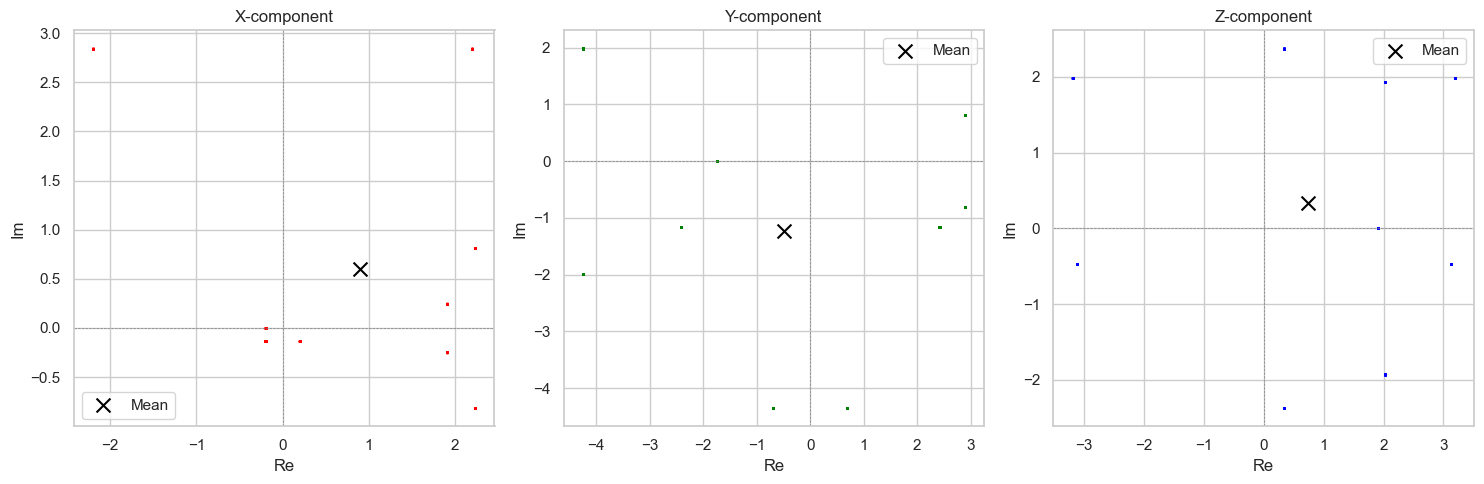


Statistiques pour la composante X:
Moyenne complexe: -3.67e-02+2.96e-02j
Variance partie réelle: 1.81e-02
Variance partie imaginaire: 2.06e-02
Moyenne des magnitudes: 1.91e-01
Variance des magnitudes: 4.48e-03

Statistiques pour la composante Y:
Moyenne complexe: -3.57e-02-4.06e-02j
Variance partie réelle: 1.18e-02
Variance partie imaginaire: 1.68e-02
Moyenne des magnitudes: 1.57e-01
Variance des magnitudes: 6.75e-03

Statistiques pour la composante Z:
Moyenne complexe: 6.30e-03+2.63e-03j
Variance partie réelle: 1.50e-02
Variance partie imaginaire: 2.02e-02
Moyenne des magnitudes: 1.68e-01
Variance des magnitudes: 6.99e-03


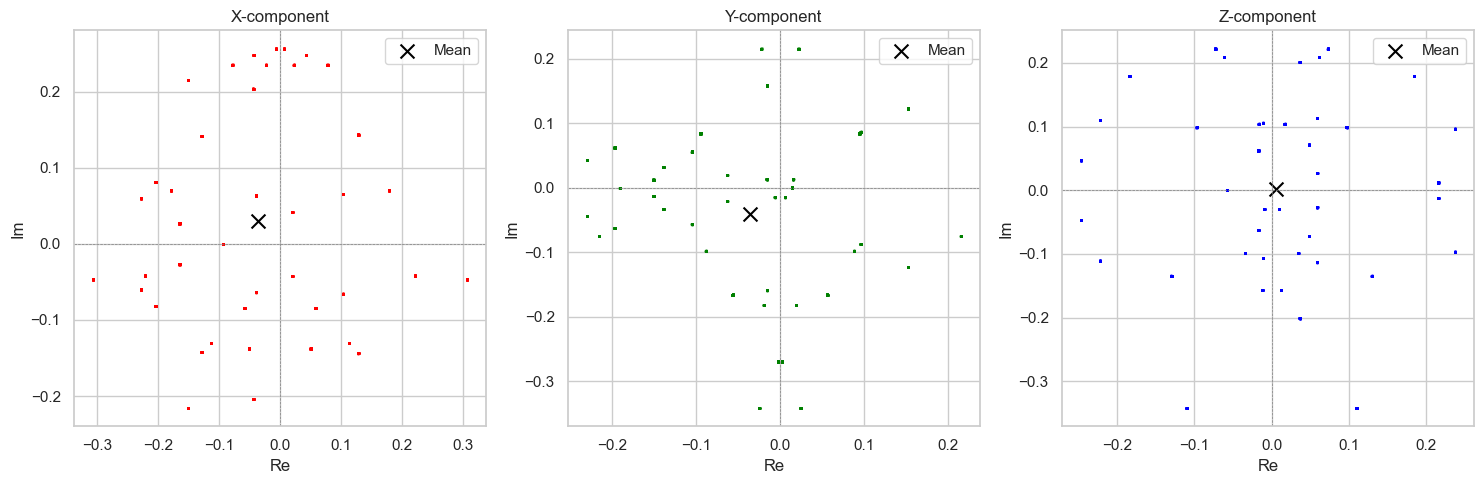

{'X': {'mean_complex': (-0.036739476787716746+0.029570564583937062j),
  'var_real': 0.018051030118498724,
  'var_imag': 0.020621154226169565,
  'mean_mag': 0.19084050944156186,
  'var_mag': 0.0044762917452013965},
 'Y': {'mean_complex': (-0.03570340076889094-0.04057300833000732j),
  'var_real': 0.011792385018357832,
  'var_imag': 0.016773577640665293,
  'mean_mag': 0.157279233441737,
  'var_mag': 0.006750107218413606},
 'Z': {'mean_complex': (0.006301422115019268+0.002626585843558469j),
  'var_real': 0.014981361333809066,
  'var_imag': 0.02020135175917658,
  'mean_mag': 0.16803313290155245,
  'var_mag': 0.006994186214140099}}

In [59]:
# Pour l'hémisphère gauche
visualize_diffs_with_stats(coeffs_all_lh, coeffs_fsav_lh, l=4)

# Pour l'hémisphère droit
visualize_diffs_with_stats(coeffs_all_rh, coeffs_fsav_rh, l=20)

In [13]:
def svd_analysis(M_svd):
    U, S, Vh = np.linalg.svd(M_svd, full_matrices=False)
    return U, S, Vh

def project_subject(subject_coeffs, principal_vectors):
    return np.dot(subject_coeffs, principal_vectors.T)

In [14]:
def matrix_svd_harmonics_all_components(l, coeffs_all):
    n_subjects = len(coeffs_all)
    M_x = np.zeros((n_subjects, 2*l+1), dtype=complex)
    M_y = np.zeros((n_subjects, 2*l+1), dtype=complex)
    M_z = np.zeros((n_subjects, 2*l+1), dtype=complex)
    
    for i, subject in enumerate(coeffs_all.keys()):
        for m in range(2*l+1):
            M_x[i,m] = coeffs_all[subject][l][m][0]
            M_y[i,m] = coeffs_all[subject][l][m][1]
            M_z[i,m] = coeffs_all[subject][l][m][2]
            
    return M_x, M_y, M_z

def get_components_for_variance_threshold(S, threshold=0.90):
    total_variance = np.sum(S)
    explained_variance_ratio = S / total_variance
    cumulative_variance = np.cumsum(explained_variance_ratio)
    k = np.argmax(cumulative_variance >= threshold) + 1
    return k

def analyze_all_components(l, coeffs_all, variance_threshold=0.90):
    M_x, M_y, M_z = matrix_svd_harmonics_all_components(l, coeffs_all)
    
    U_x, S_x, Vh_x = svd_analysis(M_x)
    U_y, S_y, Vh_y = svd_analysis(M_y)
    U_z, S_z, Vh_z = svd_analysis(M_z)
    
    k_x = get_components_for_variance_threshold(S_x, variance_threshold)
    k_y = get_components_for_variance_threshold(S_y, variance_threshold)
    k_z = get_components_for_variance_threshold(S_z, variance_threshold)
    
    return {
        'matrices': (M_x, M_y, M_z),
        'U': (U_x, U_y, U_z),
        'S': (S_x, S_y, S_z),
        'Vh': (Vh_x, Vh_y, Vh_z),
        'principal_vectors': (Vh_x[:k_x,:], Vh_y[:k_y,:], Vh_z[:k_z,:]),
        'n_components': (k_x, k_y, k_z),
        'dims': 2*l + 1,
        'explained_variance_ratio': (S_x/np.sum(S_x), S_y/np.sum(S_y), S_z/np.sum(S_z))
    }



In [15]:
#Visualization of the first component of the svd for a given l
l=25
ls=[]
for x in coeffs_all_lh:
    results=analyze_all_components(l, coeffs_all_lh, variance_threshold=0.9)
    p_x, p_y, p_z = results["principal_vectors"]
    lx=project_subject(coeffs_all_lh[x][l].T[0],p_x)
    ls.append(lx)
ls=np.array(ls)

In [18]:
def generate_surface_SVD(Y, subject_coeffs, lmin, lmax, coeffs_all_lh):
    N_points = Y.shape[0]
    xyz_total = np.zeros((N_points, 3), dtype=np.complex128)
    
    P_x = np.array([]) 
    P_y = np.array([])
    P_z = np.array([])
    
    # Dimensions intactes jusqu'à lmin
    dims_intact = 3*(lmin+1)**2
    
    # Dimensions PCA pour lmin+1 jusqu'à lmax
    dims_pca = 0
    
    # Garder intact jusqu'à lmin
    for l in range(lmin+1):
        P_x = np.hstack((P_x, subject_coeffs[l].T[0]))
        P_y = np.hstack((P_y, subject_coeffs[l].T[1]))
        P_z = np.hstack((P_z, subject_coeffs[l].T[2]))

    # PCA de lmin+1 à lmax
    for l in range(lmin+1, lmax+1):
        results = analyze_all_components(l, coeffs_all_lh, variance_threshold=1)
        p_x, p_y, p_z = results["principal_vectors"]
        
        dims_pca += sum(results['n_components'])
        
        proj_x = project_subject(subject_coeffs[l].T[0], p_x)
        proj_y = project_subject(subject_coeffs[l].T[1], p_y)
        proj_z = project_subject(subject_coeffs[l].T[2], p_z)
        
        P_x = np.hstack((P_x, np.dot(proj_x, p_x)))
        P_y = np.hstack((P_y, np.dot(proj_y, p_y)))
        P_z = np.hstack((P_z, np.dot(proj_z, p_z)))

    xyz_total[:,0] = Y[:,:(lmax+1)**2] @ P_x
    xyz_total[:,1] = Y[:,:(lmax+1)**2] @ P_y
    xyz_total[:,2] = Y[:,:(lmax+1)**2] @ P_z
    
    return np.real(xyz_total), dims_intact, dims_pca

In [ ]:
# def find_matching_l(target_dims):
#     l = 0
#     while 3*(l+1)**2 <= target_dims:
#         l += 1
#     return l
# lmin1= -1
# lmax1=30
# coords_pca, dims_intact, dims_pca = generate_surface_SVD(Y, subject_coeffs, lmin1, lmax1, coeffs_all_lh)
# total_dims = dims_intact + dims_pca

# l_equiv = find_matching_l(total_dims)
# coords_direct = SH.generate_surface(Y, l_equiv, 0, subject_coeffs)

# print(f"Original dimensions: {3*(lmax1+1)**2}")
# print(f"Our method: {dims_intact} (intact) + {dims_pca} (PCA) = {total_dims}")
# print(f"Equivalent l={l_equiv} giving {3*(l_equiv+1)**2} dimensions")



# # Original surface
# coords_original = np.load(os.path.join(sub_file, "lh_resampled.npz"))["coords"]

# # Errors
# error_pca = hausdorff_distance(coords_original, coords_pca) / np.max(np.ptp(coords_original, axis=0))
# error_direct = hausdorff_distance(coords_original, coords_direct) / np.max(np.ptp(coords_original, axis=0))

# print(f"PCA error: {error_pca}")
# print(f"Direct error (l={l_equiv}): {error_direct}")
# # Visualization
# p = pv.Plotter(shape=(1, 3))
# tris = convert_triangles_to_pyvista(template_projection["sphere_tris"])

# p.subplot(0, 0)
# p.add_mesh(pv.PolyData(coords_pca, tris), show_edges=True)
# p.add_text("PCA", position='upper_edge')

# p.subplot(0, 1)
# p.add_mesh(pv.PolyData(coords_direct, tris), show_edges=True)
# p.add_text("Direct", position='upper_edge')

# p.subplot(0, 2)
# p.add_mesh(pv.PolyData(coords_original, tris), show_edges=True)
# p.add_text("Original", position='upper_edge')

# p.link_views()
# p.show()

In [ ]:
def compare_methods(Y, subject_coeffs, lmin, lmax, coeffs_all_lh, sub_file):
    # PCA method
    coords_pca, dims_intact, dims_pca = generate_surface_SVD(Y, subject_coeffs, lmin, lmax, coeffs_all_lh)
    total_dims = dims_intact + dims_pca
    
    # Direct method with equivalent dimensions
    l_equiv = find_matching_l(total_dims)
    coords_direct = SH.generate_surface(Y, l_equiv, 0, subject_coeffs)
    
    # Original surface
    resampled_data = np.load(os.path.join(sub_file, "lh_resampled.npz"))
    coords_original = resampled_data['coords']
    tris = resampled_data['tris']
    
    # Compute metrics for original vs PCA
    orig_metrics = compute_raw_surface_metrics(coords_original, tris)
    pca_metrics = compute_raw_surface_metrics(coords_pca, tris)
    direct_metrics = compute_raw_surface_metrics(coords_direct, tris)
    
    # Compare metrics
    comparison_pca = compare_surface_metrics(orig_metrics, pca_metrics)
    comparison_direct = compare_surface_metrics(orig_metrics, direct_metrics)
    
    print("\nDimension Analysis:")
    print(f"Original dimensions: {3*(lmax+1)**2}")
    print(f"PCA method: {dims_intact} (intact) + {dims_pca} (PCA) = {total_dims}")
    print(f"Direct method (l={l_equiv}): {3*(l_equiv+1)**2}")
    
    print("\nError Metrics:")
    print("PCA method:")
    for metric in ['point', 'hausdorff', 'geodesic', 'angle', 'area']:
        print(f"- {metric}: {comparison_pca['global_metrics'][metric]:.6f}")
    
    print("\nDirect method:")
    for metric in ['point', 'hausdorff', 'geodesic', 'angle', 'area']:
        print(f"- {metric}: {comparison_direct['global_metrics'][metric]:.6f}")
    
    return comparison_pca, comparison_direct

# Test pour différentes valeurs de lmin
for lmin in [15, 20, 25]:
    print(f"\nTesting with lmin={lmin}:")
    compare_methods(Y, subject_coeffs, lmin, lmax1, coeffs_all_lh, sub_file)

Study of the geometrical deformation after a little change of the coefficients given a order

In [ ]:
#

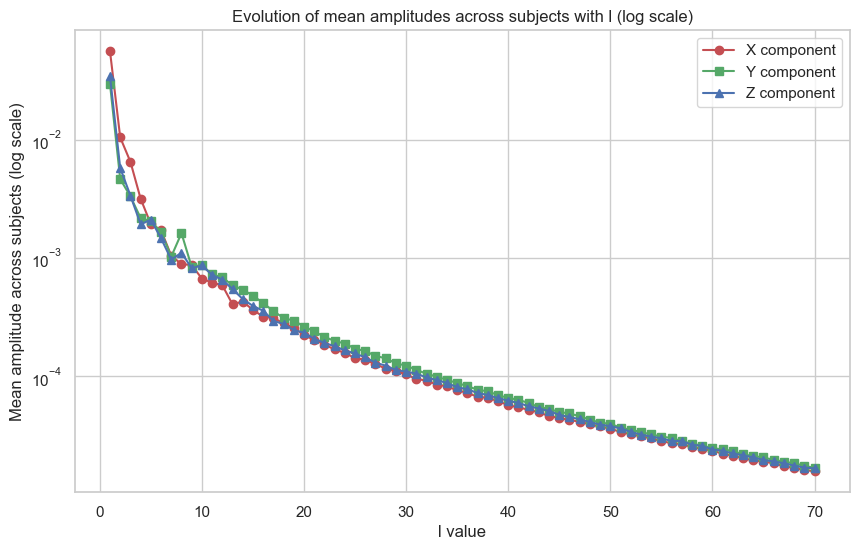

In [5]:
def extract_complex_coeffs(coeffs_all, l_value):
    coeffs_x = []
    coeffs_y = []
    coeffs_z = []
    
    for subject in coeffs_all:
        for m in range(-l_value, l_value + 1):
            vector = coeffs_all[subject][l_value][m]
            coeffs_x.append(vector[0])
            coeffs_y.append(vector[1])
            coeffs_z.append(vector[2])
    
    coeffs_x = np.array(coeffs_x)
    coeffs_y = np.array(coeffs_y)
    coeffs_z = np.array(coeffs_z)
    
    mean_magn_x = np.mean(np.abs(coeffs_x))
    mean_magn_y = np.mean(np.abs(coeffs_y))
    mean_magn_z = np.mean(np.abs(coeffs_z))
    
    return coeffs_x, coeffs_y, coeffs_z, mean_magn_x, mean_magn_y, mean_magn_z

def analyze_l_evolution(coeffs_all, l_min, l_max):
    l_values = range(l_min,l_max + 1)
    mean_x = []
    mean_y = []
    mean_z = []
    
    for l in l_values:
        _, _, _, mean_magn_x, mean_magn_y, mean_magn_z = extract_complex_coeffs(coeffs_all, l)
        mean_x.append(mean_magn_x)
        mean_y.append(mean_magn_y)
        mean_z.append(mean_magn_z)
    
    mean_x = np.array(mean_x)
    mean_y = np.array(mean_y)
    mean_z = np.array(mean_z)
    
    plt.figure(figsize=(10, 6))
    plt.semilogy(l_values, mean_x, 'r-', label='X component', marker='o')
    plt.semilogy(l_values, mean_y, 'g-', label='Y component', marker='s')
    plt.semilogy(l_values, mean_z, 'b-', label='Z component', marker='^')
    plt.xlabel('l value')
    plt.ylabel('Mean amplitude across subjects (log scale)')  # Modifié ici
    plt.title('Evolution of mean amplitudes across subjects with l (log scale)')  # Et ici
    plt.grid(True)
    plt.legend()
    
    return np.array(l_values), mean_x, mean_y, mean_z

# Usage example:
l_values, mean_x, mean_y, mean_z = analyze_l_evolution(coeffs_all_lh,1,70)

In [94]:
def analyze_complex_coeffs(coeffs_all, l_value):
    # Extraction des coefficients
    coeffs_x, coeffs_y, coeffs_z = [], [], []
    
    for subject in coeffs_all:
        for m in range(-l_value, l_value + 1):
            vector = coeffs_all[subject][l_value][m]
            coeffs_x.append(vector[0])
            coeffs_y.append(vector[1])
            coeffs_z.append(vector[2])
    
    coeffs_x = np.array(coeffs_x)
    coeffs_y = np.array(coeffs_y)
    coeffs_z = np.array(coeffs_z)
    
    # Test d'uniformité pour les phases (Rayleigh)
    def rayleigh_test(phases):
        n = len(phases)
        R = np.sqrt((np.sum(np.cos(phases)))**2 + (np.sum(np.sin(phases)))**2)
        Z = R**2 / n
        p_value = np.exp(-Z)
        return Z, p_value
    
    # Analyse et visualisation
    fig = plt.figure(figsize=(15, 12))
    components = [
        (coeffs_x, 'X', 'red'),
        (coeffs_y, 'Y', 'green'),
        (coeffs_z, 'Z', 'blue')
    ]
    results = []
    
    for i, (coeffs, comp_name, color) in enumerate(components):
        # Phases des coefficients
        phases = np.angle(coeffs)
        
        # Test de Rayleigh pour uniformité
        stat, p_val = rayleigh_test(phases)
        results.append({
            'component': comp_name,
            'rayleigh_stat': stat,
            'p_value': p_val
        })
        
        # Visualisation du plan complexe
        ax1 = plt.subplot(3, 3, 3 * i + 1)
        ax1.scatter(coeffs.real, coeffs.imag, alpha=0.5, color=color, s=1)
        ax1.axhline(0, color='gray', linestyle='--', linewidth=0.5)
        ax1.axvline(0, color='gray', linestyle='--', linewidth=0.5)
        ax1.set_title(f'{comp_name}-component: Complex Plane')
        ax1.set_xlabel('Re')
        ax1.set_ylabel('Im')
        ax1.grid(True)
        
        # Distribution des magnitudes
        ax2 = plt.subplot(3, 3, 3 * i + 2)
        magnitudes = np.abs(coeffs)
        ax2.hist(magnitudes, bins=30, density=True, alpha=0.7, color=color)
        ax2.set_title(f'{comp_name}-component: Magnitude Distribution')
        ax2.set_xlabel('Magnitude')
        
        # Distribution des phases
        ax3 = plt.subplot(3, 3, 3 * i + 3, projection='polar')
        ax3.hist(phases, bins=30, density=True, alpha=0.7, color=color)
        ax3.set_title(f'{comp_name}-component: Phase Distribution')
    
    plt.tight_layout()
    return fig, results


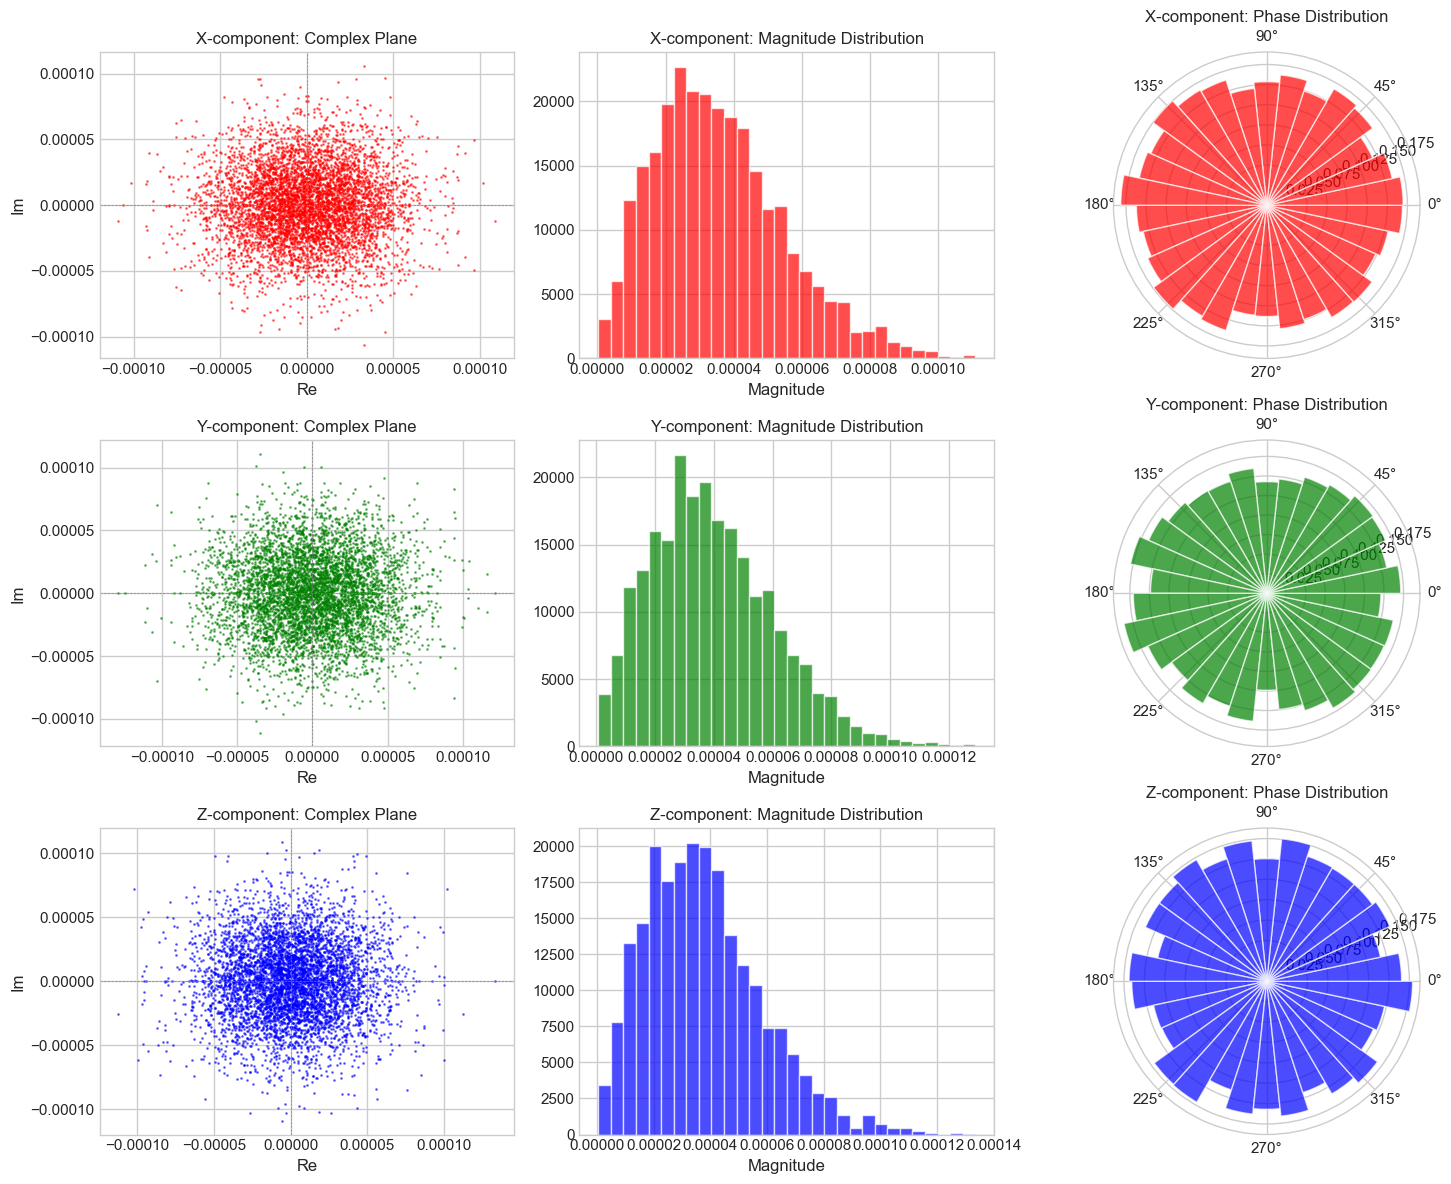

In [96]:
fig, results = analyze_complex_coeffs(coeffs_all_lh, 50)

# Affichage des résultats du test de Rayleigh pour chaque composante

# Affichage des graphiques
plt.show()


In [15]:
def plot_coeffs_distribution_lm(coeffs_all, l_value, m_value):
    # Extract coefficients
    coeffs_x = []
    coeffs_y = []
    coeffs_z = []
    
    for subject in coeffs_all:
        vector = coeffs_all[subject][l_value][m_value]
        coeffs_x.append(vector[0])
        coeffs_y.append(vector[1])
        coeffs_z.append(vector[2])
    
    coeffs_x = np.array(coeffs_x)
    coeffs_y = np.array(coeffs_y)
    coeffs_z = np.array(coeffs_z)
    
    # Create figure with 3 rows and 3 columns
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    
    colors = ['red', 'green', 'blue']
    cmaps = ['Reds', 'Greens', 'Blues']
    components = [(coeffs_x, 'X'), (coeffs_y, 'Y'), (coeffs_z, 'Z')]
    
    for i, (coeffs, comp_name) in enumerate(components):
        ax1, ax2, ax3 = axes[i]
        
        # Distribution dans le plan complexe
        sns.kdeplot(x=coeffs.real, y=coeffs.imag, ax=ax1, cmap=cmaps[i], fill=True)
        ax1.scatter(coeffs.real, coeffs.imag, alpha=0.2, color=colors[i], label=f'{comp_name}-component')
        ax1.set_title(f'{comp_name}-component: Complex plane (l={l_value}, m={m_value})')
        ax1.set_xlabel('Real part')
        ax1.set_ylabel('Imaginary part')
        ax1.grid(True)
        ax1.legend()
        
        # Magnitude
        sns.histplot(data=np.abs(coeffs), ax=ax2, kde=True, color=colors[i])
        ax2.set_title(f'{comp_name}-component: Magnitude')
        ax2.set_xlabel('|coefficient|')
        
        # Phase
        phases = np.angle(coeffs, deg=True)  # Convert to degrees
        sns.histplot(data=phases, ax=ax3, kde=True, color=colors[i])
        ax3.set_title(f'{comp_name}-component: Phase')
        ax3.set_xlabel('Phase (degrees)')
        
    plt.tight_layout()
    return fig

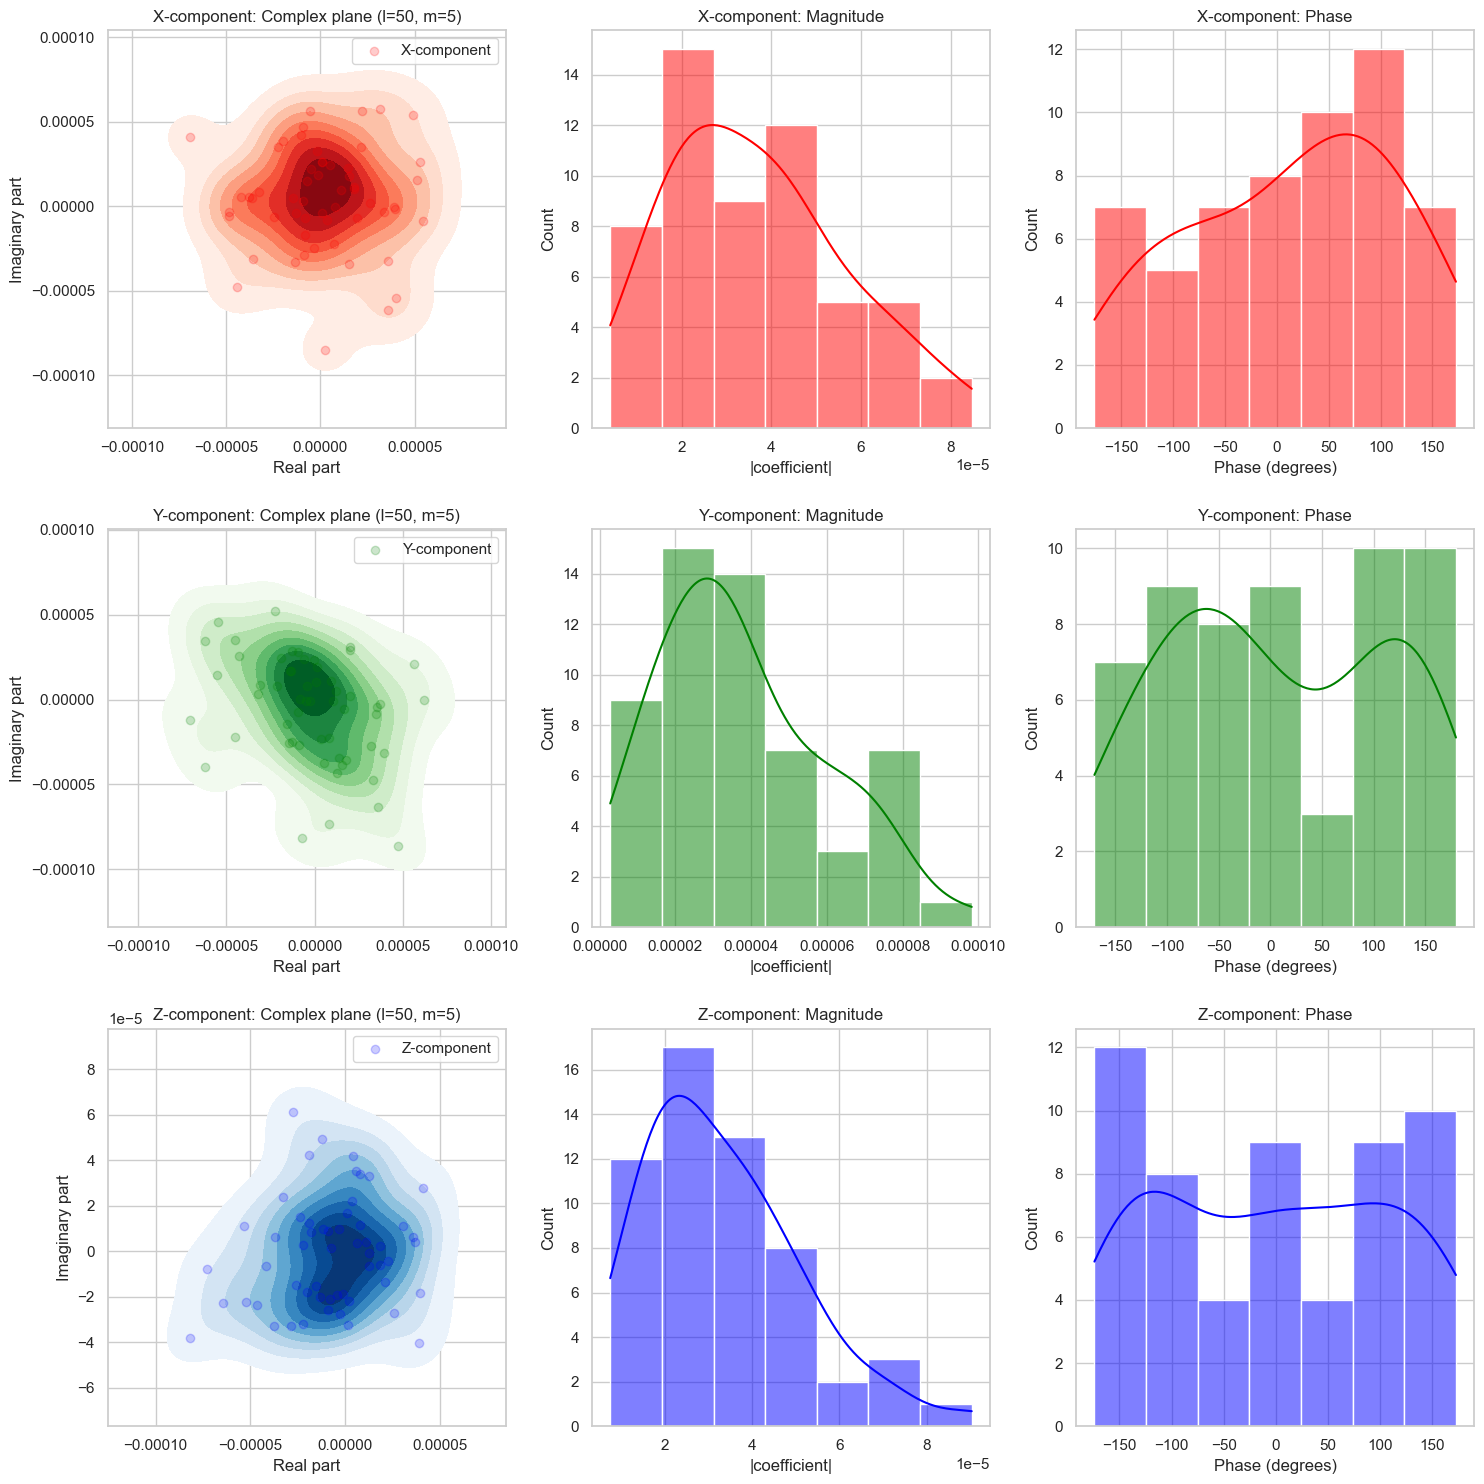

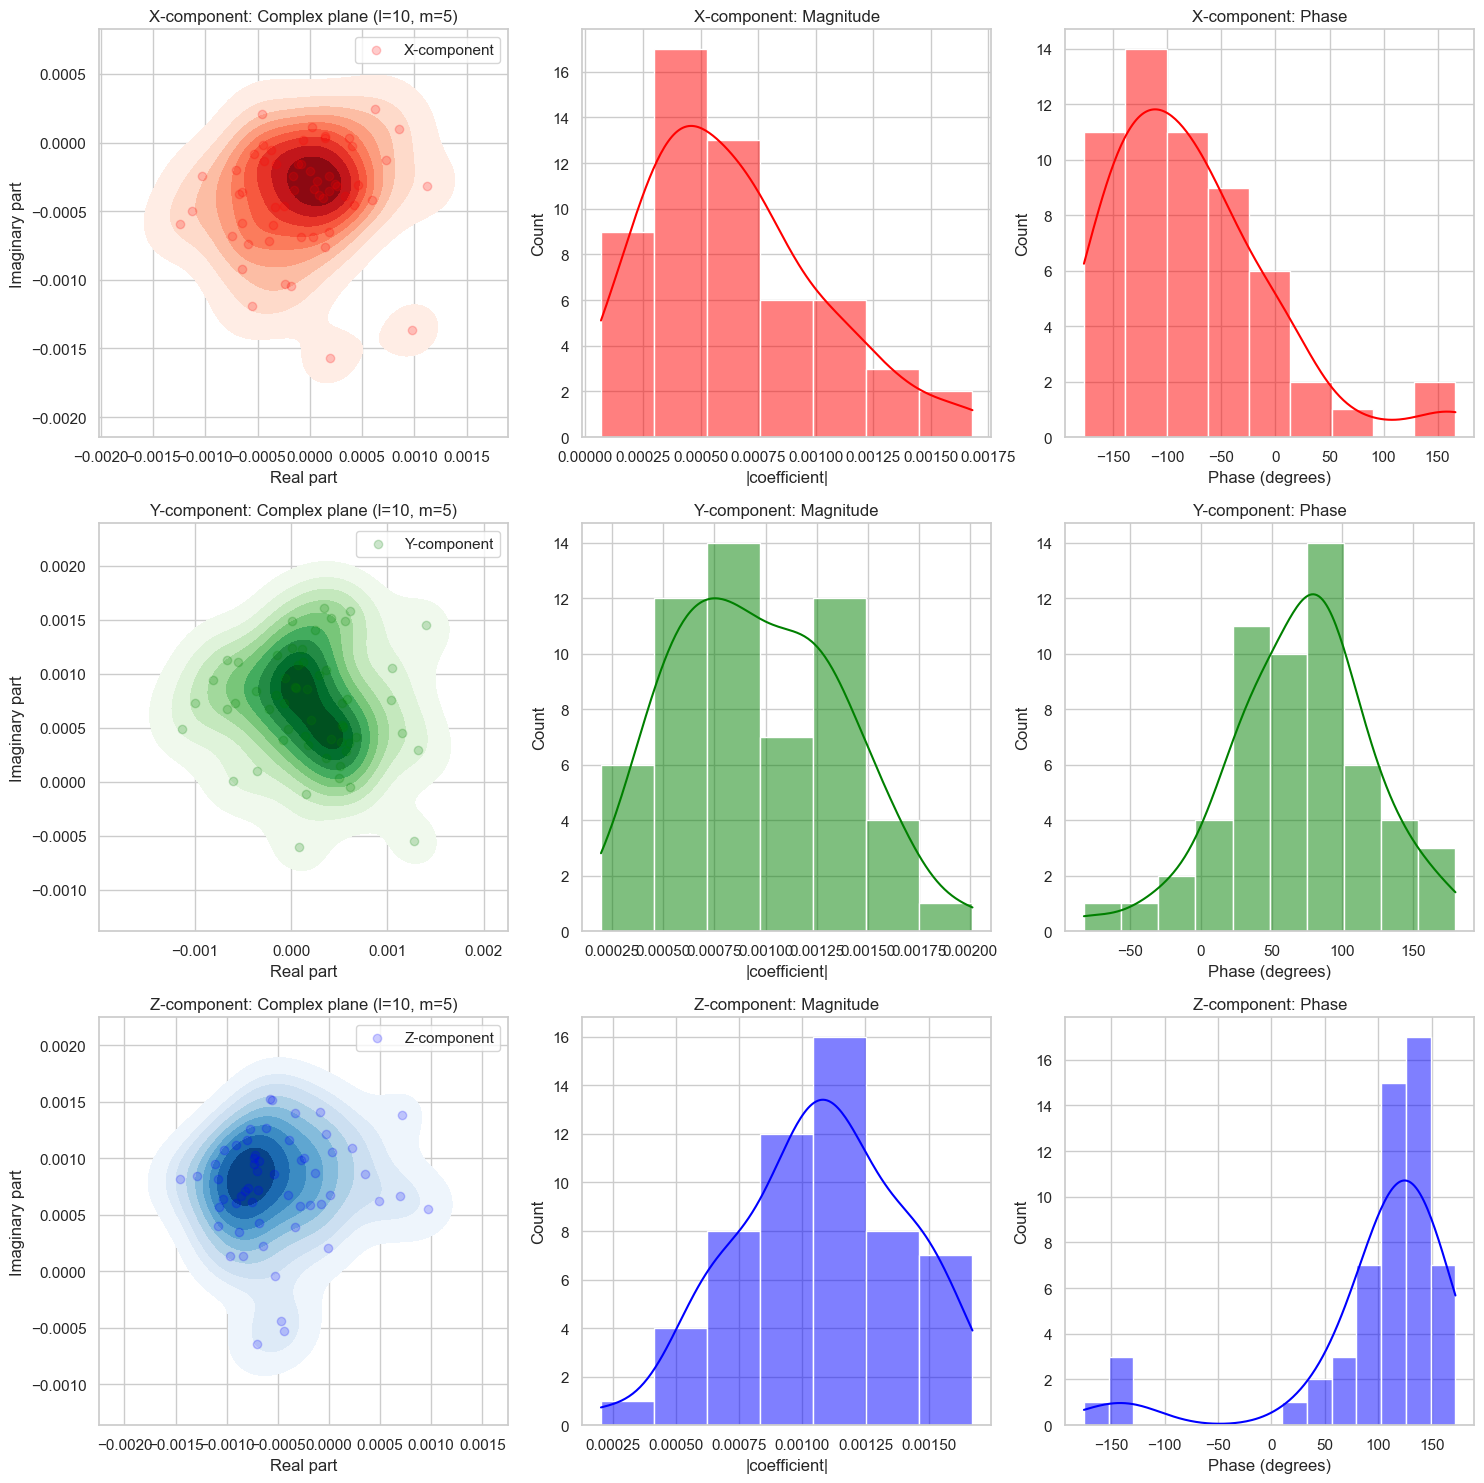

In [17]:
fig = plot_coeffs_distribution_lm(coeffs_all_lh,50,5)
fig = plot_coeffs_distribution_lm(coeffs_all_lh,10,5)
# fig = plot_coeffs_distribution_lm(coeffs_all_lh,10,-2)

In [15]:
#Utils 

def change_representations(coeffs_dic):
    lmax=coeffs_dic["lmax"]
    coeffs=coeffs_dic["organized_coeffs"]
    a = {l: [] for l in range(lmax+1)}
    b = {l: [] for l in range(lmax+1)}
    for l in range(lmax+1):
        a[l].append(coeffs[l][l].real)  
        b[l].append(np.array([0.,0.,0.]))  
        for m in range(1, l+1):
            # For C_lm : index l+m
            # For C_l(-m) : index l-m
            a[l].append(coeffs[l][l+m].real + ((-1)**m)*coeffs[l][l-m].real)
            b[l].append(((-1)**m)*coeffs[l][l-m].imag - coeffs[l][l+m].imag)
    return a, b

def spectral_power_order(a, b, l):
    return np.sum(np.array(a[l])**2 + np.array(b[l])**2, axis=0)

def spectral_power_coords(a,b,lmax):
    s_p=np.sum(np.array([spectral_power_order(a,b,l) for l in range(lmax+1)]), axis=0)
    return s_p

def spectral_power_dims_order(a, b, l):
    power = np.zeros(3)
    for i in range(3):
        power[i] = np.sum(np.array(a[l])[:,i]**2 + np.array(b[l])[:,i]**2)
    return power

def spectral_power_total(a,b,lmax):
    s_p=spectral_power_coords(a,b,lmax)
    return np.sum(s_p)

def correlation_order(u,v,l):
    a_u,b_u = u
    a_v,b_v = v
    return np.sum(np.array(a_u[l])*np.array(a_v[l])+(np.array(b_u[l])*np.array(b_v[l])),axis=0)

def correlation_coords(u,v,lmax):
     c_c=np.sum(np.array([correlation_order(u,v,l) for l in range(lmax+1)]), axis=0)
     return c_c

def correlation_dims_order(u,v,l):
   a_u,b_u = u
   a_v,b_v = v
   corr = np.zeros((3,3))
   for i in range(3):
       for j in range(3):
           corr[i,j] = np.sum(np.array(a_u[l])[:,i]*np.array(a_v[l])[:,j] + np.array(b_u[l])[:,i]*np.array(b_v[l])[:,j])
   return corr

def correlation_total(u,v,lmax):  
    return np.sum(correlation_coords(u,v,lmax))

In [42]:
def coherence_order(u, v, l):
    a_u, b_u = u
    a_v, b_v = v
    
    # Pour chaque composante, on calcule la cohérence entre les mêmes dimensions
    coherence = np.zeros(3)
    for i in range(3):  # i est la composante (x,y,z)
        u_complex = np.array(a_u[l])[:,i] + 1j * np.array(b_u[l])[:,i]
        v_complex = np.array(a_v[l])[:,i] + 1j * np.array(b_v[l])[:,i]
        
        # Spectre croisé pour une seule composante
        cross_spectrum = np.sum(u_complex * np.conjugate(v_complex))
        
        # Auto-spectres pour la même composante
        power_u = np.sum(np.abs(u_complex)**2)
        power_v = np.sum(np.abs(v_complex)**2)
        
        coherence[i] = np.abs(cross_spectrum)**2 / (power_u * power_v)
            
    return coherence


def compute_mean_coherence(coeffs_ab, lmax):
   coherences = {l: [] for l in range(lmax+1)}
   
   for i, participant1 in enumerate(coeffs_ab):
       for j, participant2 in enumerate(coeffs_ab):
           if i < j:
               for l in range(lmax+1):
                   coh = coherence_order(
                       (coeffs_ab[participant1]['lh'][0], coeffs_ab[participant1]['lh'][1]),
                       (coeffs_ab[participant2]['lh'][0], coeffs_ab[participant2]['lh'][1]),
                       l
                   )
                   coherences[l].append(coh)
   
   mean_coherences = [np.mean(coherences[l], axis=0) for l in range(1, lmax+1)]
   return np.array(mean_coherences)


In [86]:
#Check of the validity of the change of representation for a subject

subj_coeffs = r'C:\Users\wbou2\Desktop\meg_to_surface_ml\data\Anatomy_data_CAM_CAN\sub-CC110033\coeffs_lh.pkl'
with open(subj_coeffs, 'rb') as f:
    coeffs_lh = pickle.load(f)

a,b=change_representations(coeffs_lh)

from scipy.special import sph_harm

def reconstruct_surface(a, b, theta, phi, lmax):
   surface = np.zeros((len(theta), 3), dtype=float)
   
   for l in range(lmax+1):
       P_l0 = sph_harm(0, l, theta, phi)
       surface += np.outer(P_l0.real, a[l][0])  
       for m in range(1, l+1):
           P_lm = sph_harm(m, l, theta, phi)
           surface +=  np.outer(P_lm.real, a[l][m]) + np.outer(P_lm.imag, b[l][m]) 
   
   return surface

theta=template_projection['theta']
phi=template_projection['phi']

coords=reconstruct_surface(a,b,theta,phi,lmax)

tris=convert_triangles_to_pyvista(template_projection["sphere_tris"])
p=pv.Plotter()
mesh=pv.PolyData(coords,tris)
p.add_mesh(mesh)
p.show()

Widget(value='<iframe src="http://localhost:3219/index.html?ui=P_0x12e2578b170_1&reconnect=auto" class="pyvist…

In [18]:
coeffs_ab = {}

for folder in os.listdir(main_folder):
   folder_path = os.path.join(main_folder, folder)
   if os.path.isdir(folder_path):
       with open(os.path.join(folder_path, "coeffs_lh.pkl"), 'rb') as f:
           coeffs_lh = pickle.load(f)
       with open(os.path.join(folder_path, "coeffs_rh.pkl"), 'rb') as f:
           coeffs_rh = pickle.load(f)
       coeffs_ab[folder] = {
           'lh': change_representations(coeffs_lh),
           'rh': change_representations(coeffs_rh)
       }

In [ ]:
lmin=15

for l in range(lmin, 71, 5):
   alh = [np.array(coeffs_ab[x]['lh'][0][l][m]).T[0] for x in coeffs_ab.keys() for m in range(l+1)]
   blh = [np.array(coeffs_ab[x]['lh'][1][l][m]).T[0] for x in coeffs_ab.keys() for m in range(l+1)]
   arh = [np.array(coeffs_ab[x]['rh'][0][l][m]).T[0] for x in coeffs_ab.keys() for m in range(l+1)]
   brh = [np.array(coeffs_ab[x]['rh'][1][l][m]).T[0] for x in coeffs_ab.keys() for m in range(l+1)]

   max_val = max([max(abs(np.array(alh))), max(abs(np.array(blh))), 
                 max(abs(np.array(arh))), max(abs(np.array(brh)))])
   limit = max_val * 1.2

   fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
   fig.suptitle(f'Distribution des coefficients pour l={l}')

   sns.histplot(data=alh, ax=ax1, color='blue', alpha=0.5, label='a', kde=True)
   sns.histplot(data=blh, ax=ax1, color='red', alpha=0.5, label='b', kde=True)
   ax1.set_title('LH - coefficients')
   ax1.set_xlim(-limit, limit)
   ax1.legend()

   sns.histplot(data=arh, ax=ax2, color='blue', alpha=0.5, label='a', kde=True)
   sns.histplot(data=brh, ax=ax2, color='red', alpha=0.5, label='b', kde=True)
   ax2.set_title('RH - coefficients')
   ax2.set_xlim(-limit, limit)
   ax2.legend()

   plt.tight_layout()
   plt.show()

Analysis from a spectrum point of view 

In [19]:
powers_lh = {l: [] for l in range(lmax+1)}
powers_rh = {l: [] for l in range(lmax+1)}

for participant in coeffs_ab:
    for l in range(lmax+1):
        powers_lh[l].append(spectral_power_order(coeffs_ab[participant]['lh'][0], coeffs_ab[participant]['lh'][1], l))
        powers_rh[l].append(spectral_power_order(coeffs_ab[participant]['rh'][0], coeffs_ab[participant]['rh'][1], l))

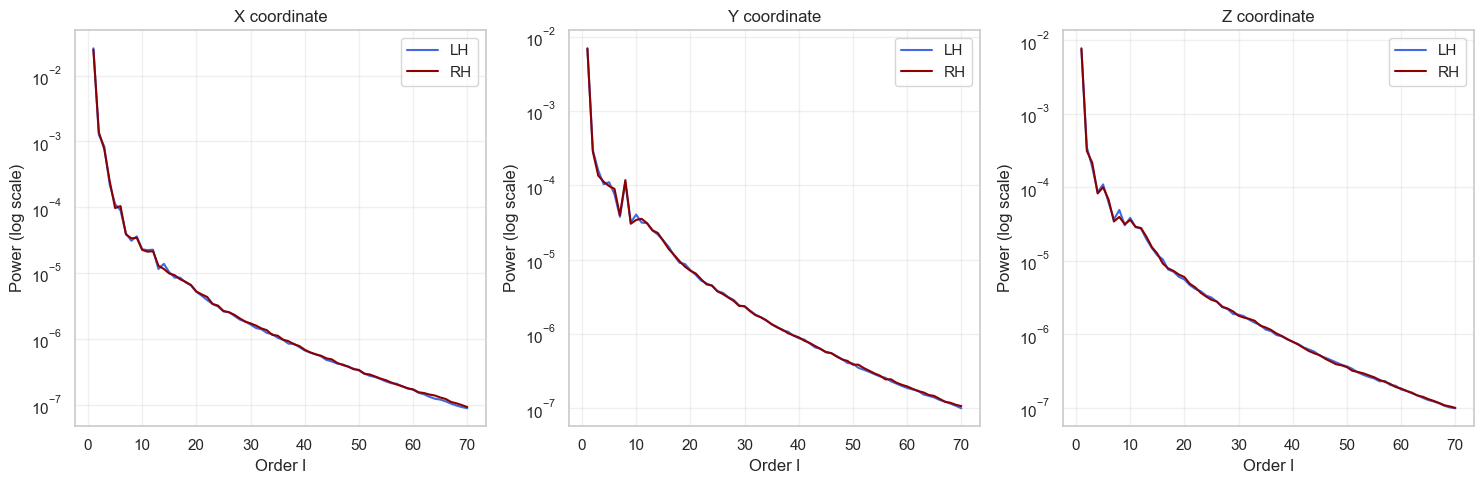

In [32]:
lmin = 1
mean_power_lh = []
mean_power_rh = []

for l in range(lmin, lmax+1):
    mean_power_lh.append(np.mean(np.array(powers_lh[l]), axis=0))
    mean_power_rh.append(np.mean(np.array(powers_rh[l]), axis=0))

mean_power_lh = np.array(mean_power_lh)
mean_power_rh = np.array(mean_power_rh)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# X coordinate
ax1.semilogy(range(lmin,lmax+1), mean_power_lh.T[0], 'royalblue', label="LH")
ax1.semilogy(range(lmin,lmax+1), mean_power_rh.T[0], 'darkred', label="RH")
ax1.set_title('X coordinate')
ax1.set_xlabel('Order l')
ax1.set_ylabel('Power (log scale)')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Y coordinate
ax2.semilogy(range(lmin,lmax+1), mean_power_lh.T[1], 'royalblue', label="LH")
ax2.semilogy(range(lmin,lmax+1), mean_power_rh.T[1], 'darkred', label="RH")
ax2.set_title('Y coordinate')
ax2.set_xlabel('Order l')
ax2.set_ylabel('Power (log scale)')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Z coordinate
ax3.semilogy(range(lmin,lmax+1), mean_power_lh.T[2], 'royalblue', label="LH")
ax3.semilogy(range(lmin,lmax+1), mean_power_rh.T[2], 'darkred', label="RH")
ax3.set_title('Z coordinate')
ax3.set_xlabel('Order l')
ax3.set_ylabel('Power (log scale)')
ax3.grid(True, alpha=0.3)
ax3.legend()

plt.tight_layout()
plt.show()
plt.show()

In [43]:
coherences = {l: [] for l in range(lmax+1)}

# Pour chaque paire de participants
for i, participant1 in enumerate(coeffs_ab):
    for j, participant2 in enumerate(coeffs_ab):
        if i < j:
            for l in range(lmax+1):
                coh = coherence_order(
                    (coeffs_ab[participant1]['lh'][0], coeffs_ab[participant1]['lh'][1]),
                    (coeffs_ab[participant2]['lh'][0], coeffs_ab[participant2]['lh'][1]),
                    l
                )
                coherences[l].append(coh)  # coh contient [cohX, cohY, cohZ]

mean_coherences = [np.mean(coherences[l], axis=0) for l in range(1, lmax+1)]
mean_coherences = np.array(mean_coherences)  # shape: (lmax, 3)



Study of the correlation

In [44]:
# Pour chaque composante (x,y,z)
for i in range(3):
   comp_coh = mean_coherences[:,i]  # Prend toutes les valeurs l pour une composante
   try:
       l_threshold = [l+1 for l,c in enumerate(comp_coh) if c < 0.7][0]
       # Vérifie que les prochaines valeurs restent sous le seuil
       next_values = comp_coh[l_threshold-1:l_threshold+2]
       if all(v < 0.7 for v in next_values):
           print(f"Composante {i}: l={l_threshold}")
       else:
           # Continue à chercher si c'était une fluctuation temporaire
           l_threshold = [l+1 for l,c in enumerate(comp_coh[l_threshold:]) if c < 0.7 and 
                        all(v < 0.7 for v in comp_coh[l:l+3])][0] + l_threshold
           print(f"Composante {i}: l={l_threshold}")
   except IndexError:
       print(f"Composante {i}: jamais < 0.7")

Composante 0: l=7
Composante 1: l=6
Composante 2: l=10


In [34]:
correlations = {l: [] for l in range(lmax+1)}

# For each pair of participants
for i, participant1 in enumerate(coeffs_ab):
   for j, participant2 in enumerate(coeffs_ab):
       if i < j:
           for l in range(lmax+1):
               corr_lh = correlation_order(
                   (coeffs_ab[participant1]['lh'][0], coeffs_ab[participant1]['lh'][1]),
                   (coeffs_ab[participant2]['lh'][0], coeffs_ab[participant2]['lh'][1]),
                   l
               )

               norm = np.sqrt(powers_lh[l][i] * powers_lh[l][j])
               correlations[l].append(corr_lh/norm)

In [35]:
mean_correlations=[np.mean(correlations[l],axis=0) for l in range(1,lmax+1)]
mean_correlations = np.array(mean_correlations)


for i in range(mean_correlations[0].shape[0]):
    comp_corr = mean_correlations.T[i]
    l_threshold = [l+1 for l,c in enumerate(comp_corr) if c <0.05][0]
    print(f"Composante {i}: l={l_threshold}")

Composante 0: l=28
Composante 1: l=30
Composante 2: l=27


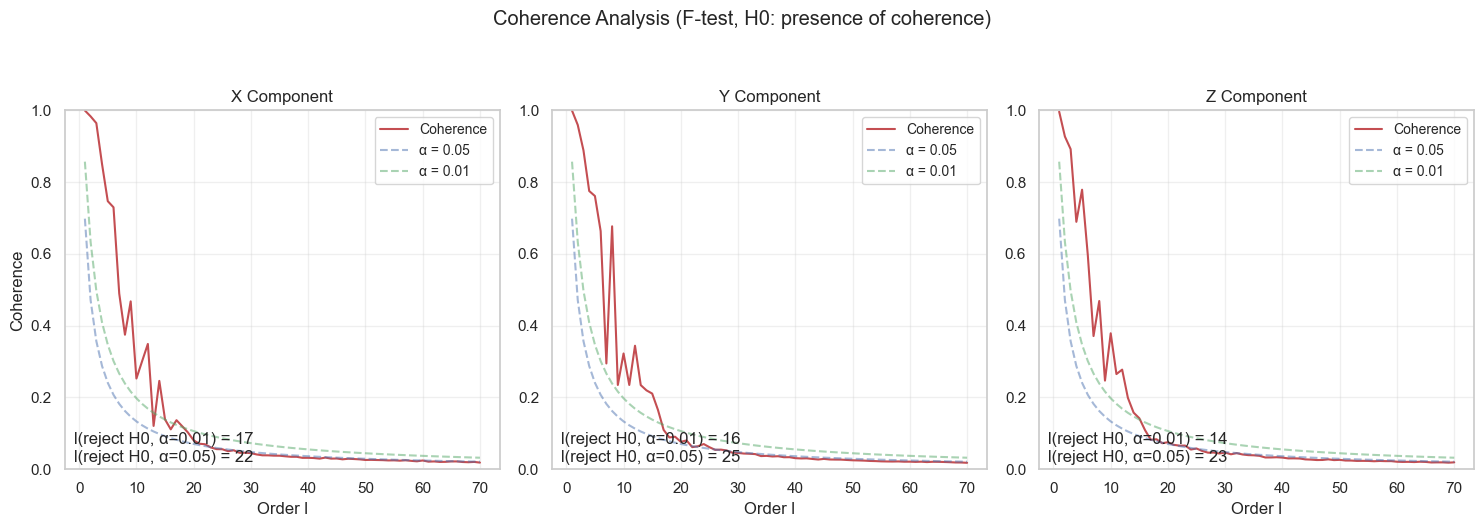

<Figure size 640x480 with 0 Axes>

In [51]:
# Calculate number of pairs
n_subjects = 56
n_pairs = (n_subjects * (n_subjects - 1)) // 2

def get_coherence_threshold(alpha, n_independent):
    """
    Test H0: présence de cohérence vs H1: absence de cohérence
    Utilise la distribution F (rapport de variances) pour tester la présence de cohérence
    """
    from scipy.stats import f
    # Les degrés de liberté sont liés à la dimension des harmoniques sphériques
    critical_value = f.ppf(1-alpha, dfn=2, dfd=2*(n_independent-1))
    # Conversion en seuil de cohérence
    threshold = critical_value / (critical_value + n_independent)
    return threshold

def get_ndof(l):
    # Degrés de liberté pour les harmoniques sphériques
    return 2*l + 1

def find_first_no_coherence(data, alpha=0.05):
    """
    Trouve le premier l où on peut rejeter H0 (présence de cohérence)
    """
    for l, value in enumerate(data[1:], start=1):
        ndof = get_ndof(l)
        threshold = get_coherence_threshold(alpha, ndof)
        if value < threshold:  # On rejette H0 si la cohérence est sous le seuil
            # Vérifie les ordres suivants pour éviter les faux positifs
            next_values = data[l:l+3]
            next_thresholds = [get_coherence_threshold(alpha, get_ndof(l+i)) for i in range(3)]
            if all(v < t for v,t in zip(next_values, next_thresholds)):
                return l
    return None

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

def setup_coherence_plot(ax, data, title):
    ax.plot(range(1,lmax+1), data, '-r', label='Coherence')
    
    # Significance levels
    l_range = range(1,lmax+1)
    thresholds_05 = [get_coherence_threshold(0.05, get_ndof(l)) for l in l_range]
    thresholds_01 = [get_coherence_threshold(0.01, get_ndof(l)) for l in l_range]
    
    ax.plot(l_range, thresholds_05, '--b', alpha=0.5, label='α = 0.05')
    ax.plot(l_range, thresholds_01, '--g', alpha=0.5, label='α = 0.01')
    
    # First l where H0 is rejected
    l_05 = find_first_no_coherence(data, 0.05)
    l_01 = find_first_no_coherence(data, 0.01)
    
    if l_05:
        ax.text(0.02, 0.02, f'l(reject H0, α=0.05) = {l_05}', transform=ax.transAxes)
    if l_01:
        ax.text(0.02, 0.07, f'l(reject H0, α=0.01) = {l_01}', transform=ax.transAxes)
    
    ax.set_xlabel('Order l')
    ax.set_ylabel("Coherence" if title == "X Component" else "")
    ax.set_title(title)
    ax.set_ylim([0, 1])
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right', fontsize='small')

# Setup each subplot
setup_coherence_plot(ax1, np.array(mean_coherences).T[0], "X Component")
setup_coherence_plot(ax2, np.array(mean_coherences).T[1], "Y Component")
setup_coherence_plot(ax3, np.array(mean_coherences).T[2], "Z Component")

plt.suptitle("Coherence Analysis (F-test, H0: presence of coherence)", y=1.05)
plt.tight_layout()
plt.show()

# Setup each subplot
setup_coherence_plot(ax1, np.array(mean_coherences).T[0], "X Component")
setup_coherence_plot(ax2, np.array(mean_coherences).T[1], "Y Component")
setup_coherence_plot(ax3, np.array(mean_coherences).T[2], "Z Component")

plt.suptitle("Coherence Analysis (F-test, H0: presence of coherence)", y=1.05)
plt.tight_layout()
plt.show()

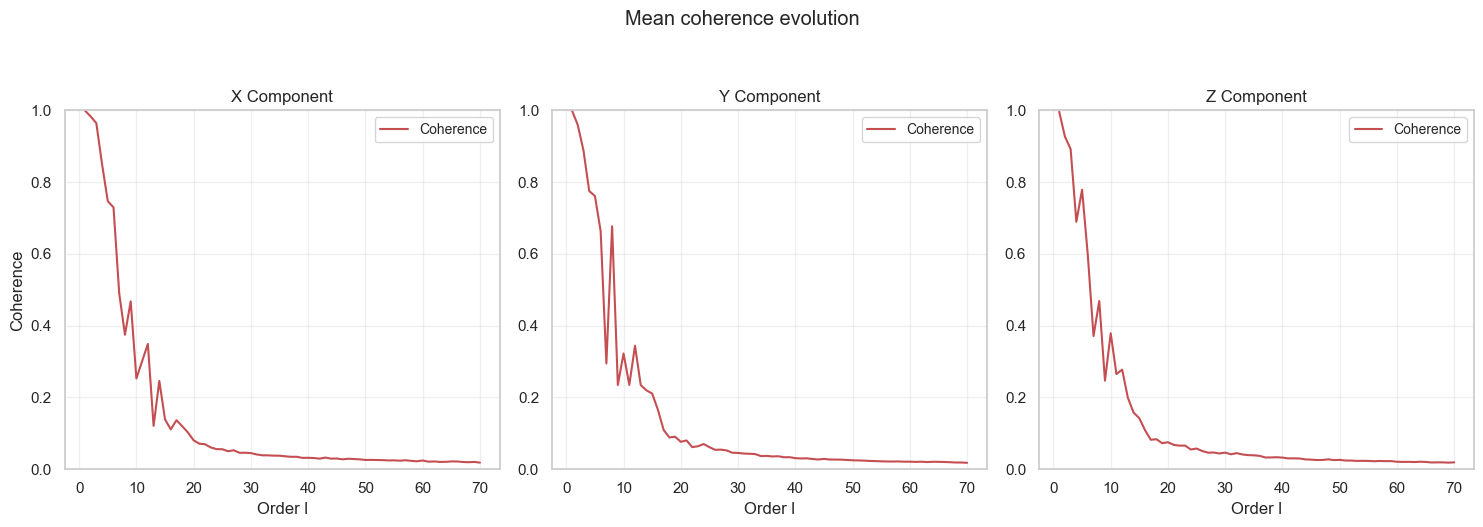

In [55]:
# Calculate number of pairs
n_subjects = 56
n_pairs = (n_subjects * (n_subjects - 1)) // 2  


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

def setup_coherence_plot(ax, data, title):
   ax.plot(range(1,lmax+1), data, '-r', label='Coherence')
   
   ax.set_xlabel('Order l')
   ax.set_ylabel("Coherence" if title == "X Component" else "")
   ax.set_title(title)
   ax.set_ylim([0, 1])
   ax.grid(True, alpha=0.3)
   ax.legend(loc='upper right', fontsize='small')

# Setup each subplot
setup_coherence_plot(ax1, mean_coherences[:,0], "X Component")
setup_coherence_plot(ax2, mean_coherences[:,1], "Y Component")
setup_coherence_plot(ax3, mean_coherences[:,2], "Z Component")

plt.suptitle("Mean coherence evolution", y=1.05)
plt.tight_layout()
plt.show()

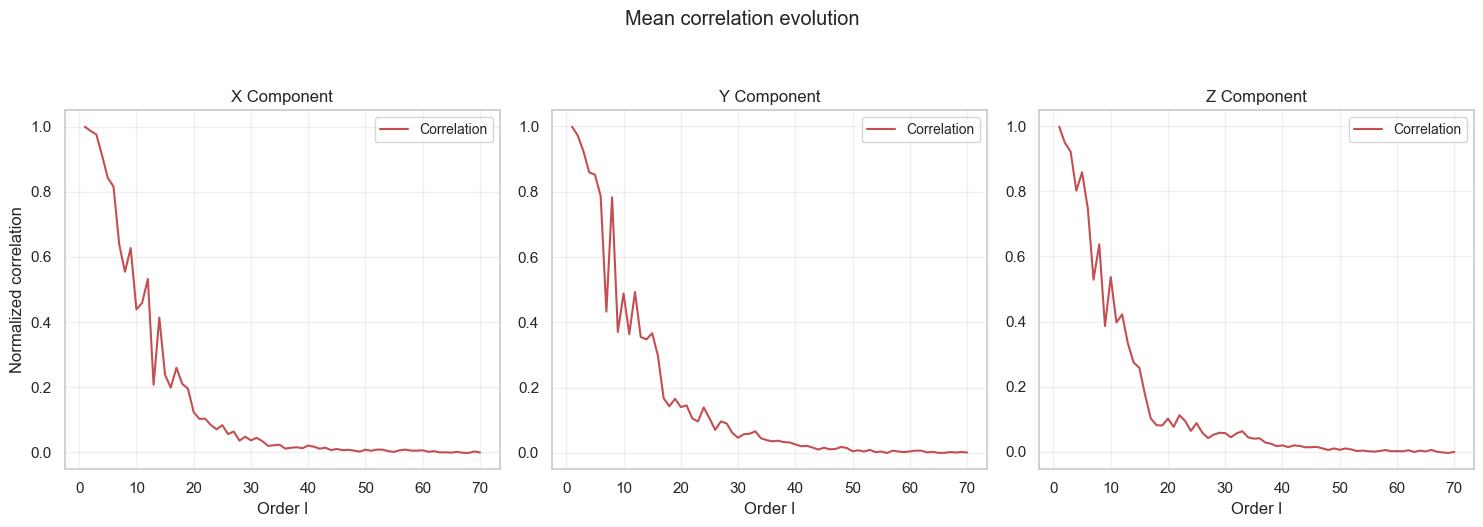

In [57]:
# Calculate number of pairs
n_subjects = 56
n_pairs = (n_subjects * (n_subjects - 1)) // 2  # 1540 pairs

# Calculate significance thresholds
from scipy.stats import norm


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

def setup_correlation_plot(ax, data, title):
    ax.plot(range(1,lmax+1), data, '-r', label='Correlation')

    ax.set_xlabel('Order l')
    ax.set_ylabel("Normalized correlation" if title == "X Component" else "")
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right', fontsize='small')

# Setup each subplot
setup_correlation_plot(ax1, np.array(mean_correlations).T[0], "X Component")
setup_correlation_plot(ax2, np.array(mean_correlations).T[1], "Y Component")
setup_correlation_plot(ax3, np.array(mean_correlations).T[2], "Z Component")

plt.suptitle("Mean correlation evolution", y=1.05)
plt.tight_layout()
plt.show()

In [60]:
def plot_correlation_heatmap(correlations, l):
    n = n_subjects
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    coords = ['x', 'y', 'z']
    titles = ['X Component', 'Y Component', 'Z Component']
    
    # Ajouter un titre global
    fig.suptitle('Correlation Matrix', fontsize=16, y=1.05)
    
    for idx, (coord, title) in enumerate(zip(coords, titles)):
        # Créer la matrice pour chaque composante
        matrix = np.ones((n, n))
        k = 0
        c = idx  # 0 pour x, 1 pour y, 2 pour z
        
        # Remplir la matrice
        for i in range(n):
            for j in range(i+1, n):
                matrix[i,j] = correlations[l][k][c]
                matrix[j,i] = correlations[l][k][c]
                k += 1
        
        # Créer le heatmap
        sns.heatmap(matrix, cmap='coolwarm', center=0, ax=axes[idx])
        axes[idx].set_title(f'{title} (l = {l})')
    
    # Ajuster l'espacement entre les subplots
    plt.tight_layout()
    plt.show()

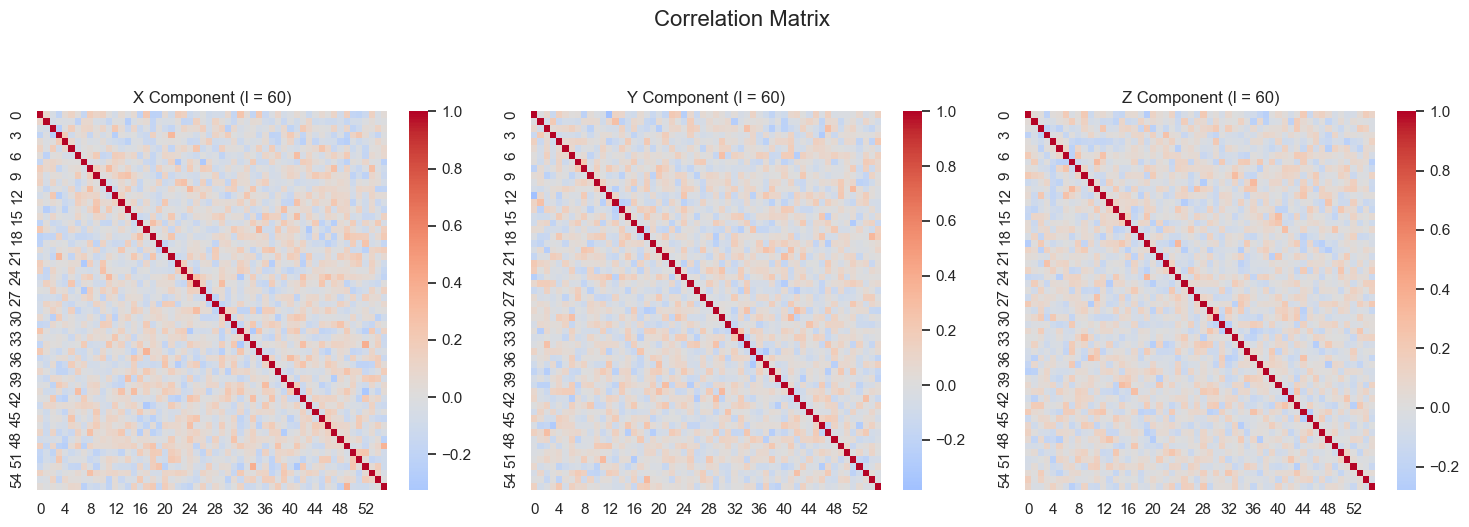

In [66]:
plot_correlation_heatmap(correlations, 60)



l between 23 and 30 seems to give proper results

In [28]:
correlations_3x3 = {l: [] for l in range(lmax+1)}

# Pour chaque participant
for i, participant in enumerate(coeffs_ab):
    # Pour chaque ordre l
    for l in range(lmax+1):
        # Calcul de la matrice 3x3 pour ce participant et ce l
        corr_matrix = np.zeros((3,3))
        for comp1 in range(3):
            for comp2 in range(3):
                corr = correlation_dims_order(
                    (coeffs_ab[participant]['lh'][0], coeffs_ab[participant]['lh'][1]),
                    (coeffs_ab[participant]['lh'][0], coeffs_ab[participant]['lh'][1]),
                    l
                )[comp1,comp2]
                
                # Normalisation avec les puissances
                norm = np.sqrt(powers_lh[l][i][comp1] * powers_lh[l][i][comp2])
                corr_matrix[comp1,comp2] = corr/norm
        
        correlations_3x3[l].append(corr_matrix)

# Pour avoir la moyenne pour chaque l
mean_correlations = {l: np.mean(correlations_3x3[l], axis=0) for l in range(lmax+1)}

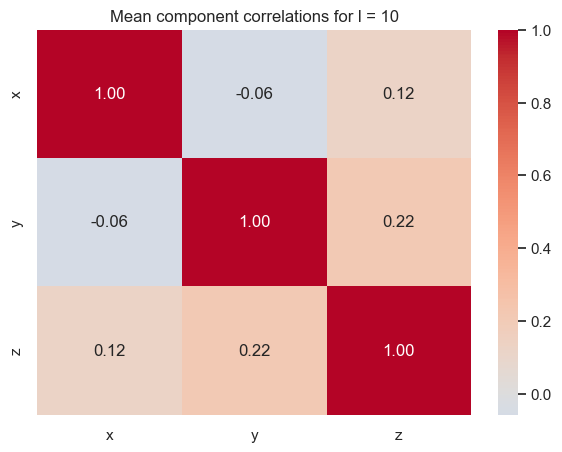

In [29]:
def plot_component_correlation_heatmap(mean_correlations, l):
   plt.figure(figsize=(7, 5))
   sns.heatmap(mean_correlations[l], 
               cmap='coolwarm', 
               center=0,
               annot=True,  # Ajoute les valeurs
               fmt='.2f',   # Format avec 2 décimales
               xticklabels=['x', 'y', 'z'],
               yticklabels=['x', 'y', 'z'])
   plt.title(f'Mean component correlations for l = {l}')
   plt.show()

# Usage:
l = 10
plot_component_correlation_heatmap(mean_correlations, l)